In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data for grid network (features and costs)
num_data = 1000 # number of data
num_feat = 5 # size of feature
num_item = 32 # number of items
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, feats, costs = pyepo.data.knapsack.genData(num_data+100+1000, num_feat, num_item, 
                                                    deg=deg, dim=dim, noise_width=noise_width)

In [3]:
from pyepo.model.grb import knapsackModel
# set solver
optmodel = knapsackModel(weights, caps)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in optmodel.items:
    if sol[i] > 1e-3:
        print(i)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Obj: 20.0
5
10
26
28


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.62it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 413.82it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 375.14it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1938.55it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn_nocost
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn_nocost, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_item)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 4), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 40
log_step = 2

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  53.2562%, Val Regret:  54.3227%


Epoch    1, Loss:  47.9671:   5%|██▊                                                    | 2/40 [00:11<01:46,  2.79s/it]

Epoch   2, Train Regret:  20.7591%, Val Regret:  19.8775%


Epoch    3, Loss:  10.6325:  10%|█████▌                                                 | 4/40 [00:18<01:47,  2.97s/it]

Epoch   4, Train Regret:  12.2839%, Val Regret:  13.0361%


Epoch    5, Loss:  11.6712:  15%|████████▎                                              | 6/40 [00:26<01:46,  3.14s/it]

Epoch   6, Train Regret:  10.6525%, Val Regret:  11.3002%


Epoch    7, Loss:   8.0528:  20%|███████████                                            | 8/40 [00:34<01:46,  3.34s/it]

Epoch   8, Train Regret:  10.0383%, Val Regret:  10.6535%


Epoch    9, Loss:   9.5082:  25%|█████████████▌                                        | 10/40 [00:44<01:44,  3.49s/it]

Epoch  10, Train Regret:   9.9181%, Val Regret:  10.3472%


Epoch   11, Loss:   4.4841:  30%|████████████████▏                                     | 12/40 [00:54<01:45,  3.76s/it]

Epoch  12, Train Regret:   9.6646%, Val Regret:  10.4833%


Epoch   13, Loss:  12.3539:  35%|██████████████████▉                                   | 14/40 [01:03<01:44,  4.01s/it]

Epoch  14, Train Regret:   9.4729%, Val Regret:  10.4152%


Epoch   15, Loss:   2.2962:  40%|█████████████████████▌                                | 16/40 [01:13<01:50,  4.60s/it]


Epoch  16, Train Regret:   9.7751%, Val Regret:  10.6535%

Early Stop!
Training Elapsed Time: 2.33 Sec

Evaluation:
Test Regret: 9.7006%
Test Elapsed Time: 6.33 Sec


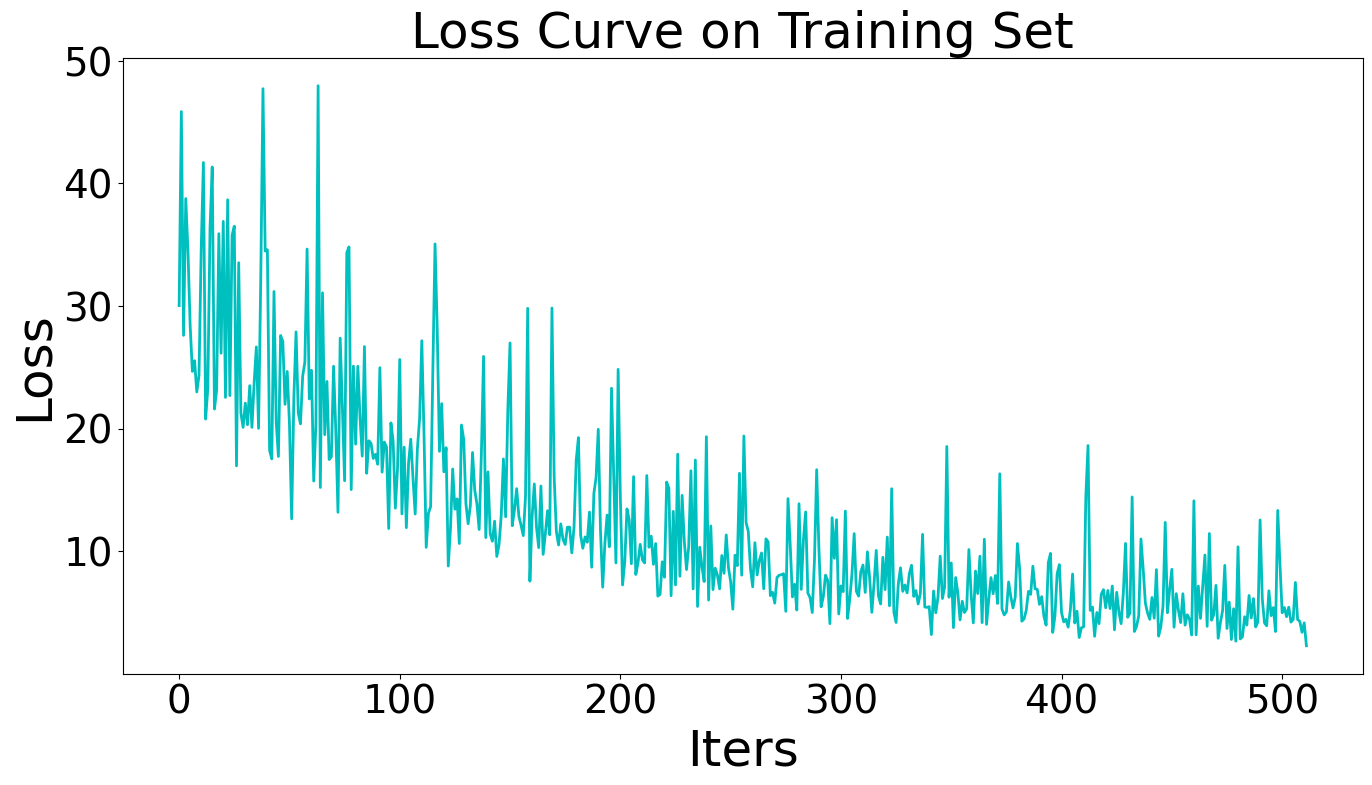

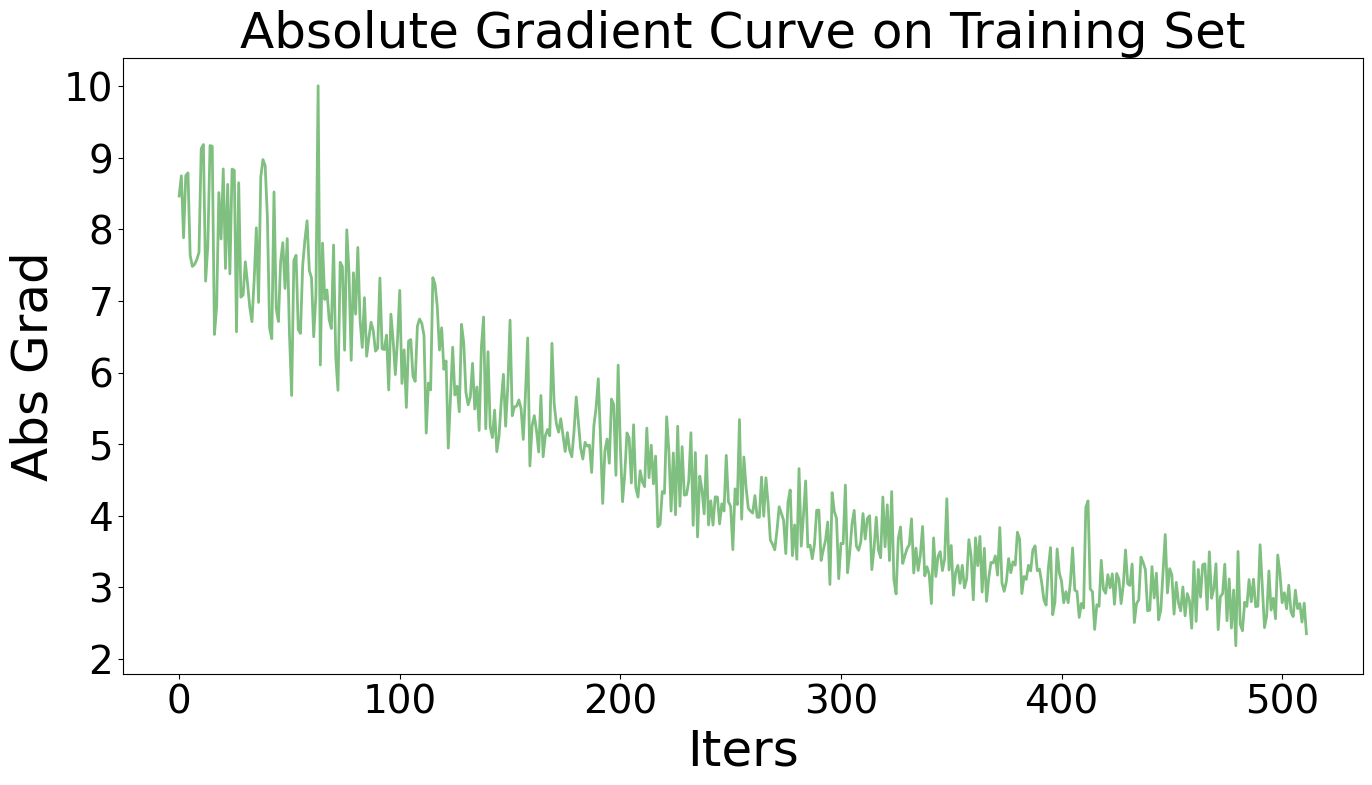

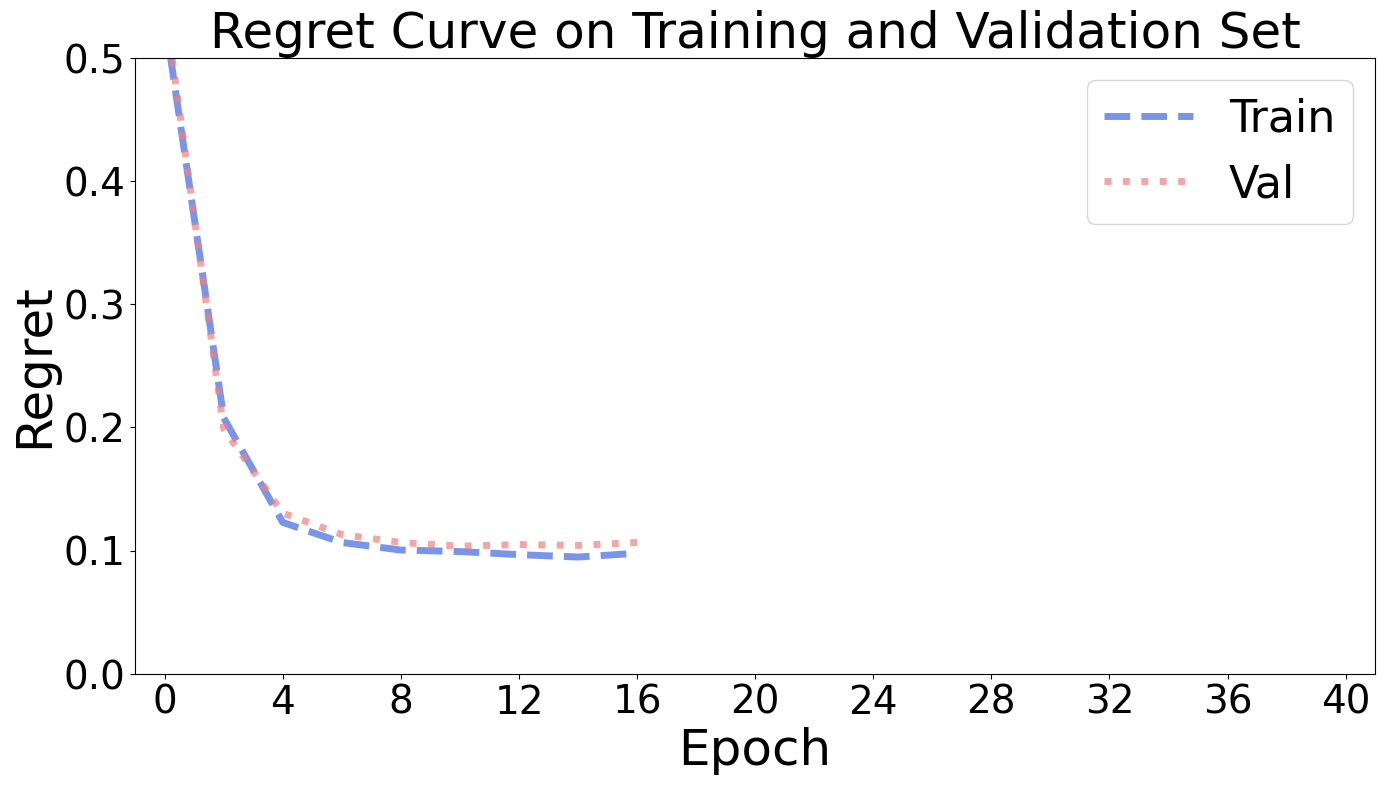

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 05 07:21:49 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  50.6369%, Val Regret:  51.2594%


Epoch    1, Loss:  -0.8645:   5%|██▊                                                    | 2/40 [00:16<03:44,  5.90s/it]

Epoch   2, Train Regret:  46.9680%, Val Regret:  47.9918%


Epoch    3, Loss:  -0.8945:  10%|█████▌                                                 | 4/40 [00:24<02:51,  4.77s/it]

Epoch   4, Train Regret:  43.1529%, Val Regret:  43.7713%


Epoch    5, Loss:  -0.8957:  15%|████████▎                                              | 6/40 [00:33<02:30,  4.42s/it]

Epoch   6, Train Regret:  39.7277%, Val Regret:  38.2233%


Epoch    7, Loss:  -0.9503:  20%|███████████                                            | 8/40 [00:42<02:15,  4.25s/it]

Epoch   8, Train Regret:  36.8159%, Val Regret:  35.4663%


Epoch    9, Loss:  -0.9597:  25%|█████████████▌                                        | 10/40 [00:50<02:05,  4.18s/it]

Epoch  10, Train Regret:  34.4794%, Val Regret:  32.8455%


Epoch   11, Loss:  -0.9522:  30%|████████████████▏                                     | 12/40 [00:59<01:55,  4.11s/it]

Epoch  12, Train Regret:  32.5816%, Val Regret:  30.9394%


Epoch   13, Loss:  -0.9888:  35%|██████████████████▉                                   | 14/40 [01:07<01:45,  4.07s/it]

Epoch  14, Train Regret:  31.0315%, Val Regret:  30.9054%


Epoch   15, Loss:  -0.9776:  40%|█████████████████████▌                                | 16/40 [01:16<01:36,  4.04s/it]

Epoch  16, Train Regret:  29.6958%, Val Regret:  30.4289%


Epoch   17, Loss:  -0.9870:  45%|████████████████████████▎                             | 18/40 [01:24<01:27,  4.00s/it]

Epoch  18, Train Regret:  29.0654%, Val Regret:  30.0204%


Epoch   19, Loss:  -0.9912:  50%|███████████████████████████                           | 20/40 [01:32<01:20,  4.02s/it]

Epoch  20, Train Regret:  28.2692%, Val Regret:  29.0334%


Epoch   21, Loss:  -0.9867:  55%|█████████████████████████████▋                        | 22/40 [01:40<01:11,  3.96s/it]

Epoch  22, Train Regret:  27.5023%, Val Regret:  29.2716%


Epoch   23, Loss:  -0.9859:  60%|████████████████████████████████▍                     | 24/40 [01:48<01:02,  3.89s/it]

Epoch  24, Train Regret:  27.1611%, Val Regret:  27.3996%


Epoch   25, Loss:  -0.9881:  65%|███████████████████████████████████                   | 26/40 [01:56<00:53,  3.80s/it]

Epoch  26, Train Regret:  27.0993%, Val Regret:  26.1743%


Epoch   27, Loss:  -0.9929:  70%|█████████████████████████████████████▊                | 28/40 [02:04<00:45,  3.75s/it]

Epoch  28, Train Regret:  27.0083%, Val Regret:  25.4935%


Epoch   29, Loss:  -0.9938:  75%|████████████████████████████████████████▌             | 30/40 [02:11<00:37,  3.73s/it]

Epoch  30, Train Regret:  27.1513%, Val Regret:  26.2764%


Epoch   31, Loss:  -0.9943:  80%|███████████████████████████████████████████▏          | 32/40 [02:19<00:29,  3.73s/it]

Epoch  32, Train Regret:  26.7711%, Val Regret:  25.9020%


Epoch   33, Loss:  -0.9941:  85%|█████████████████████████████████████████████▉        | 34/40 [02:27<00:25,  4.33s/it]


Epoch  34, Train Regret:  27.0798%, Val Regret:  27.2975%

Early Stop!
Training Elapsed Time: 70.61 Sec

Evaluation:
Test Regret: 25.0665%
Test Elapsed Time: 1.64 Sec


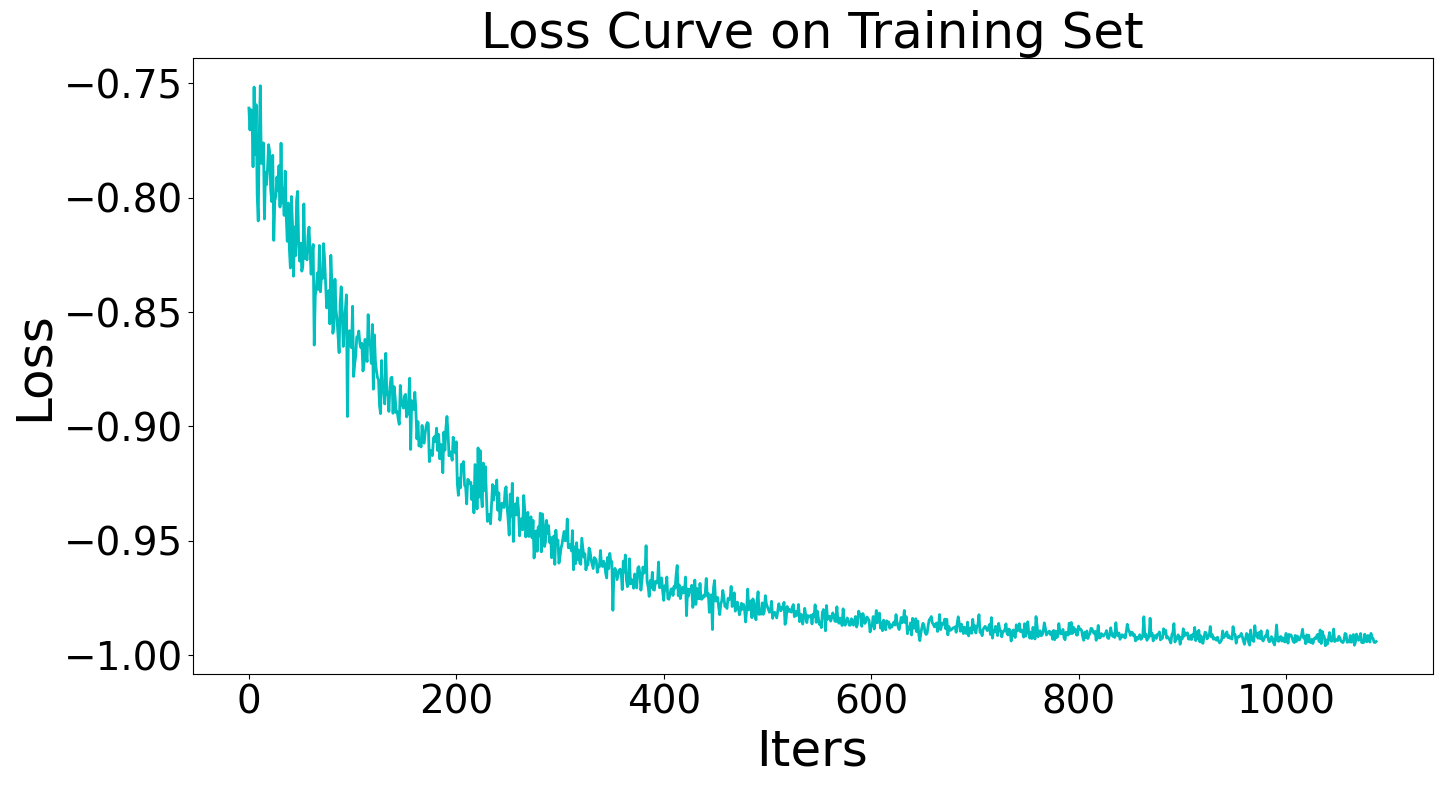

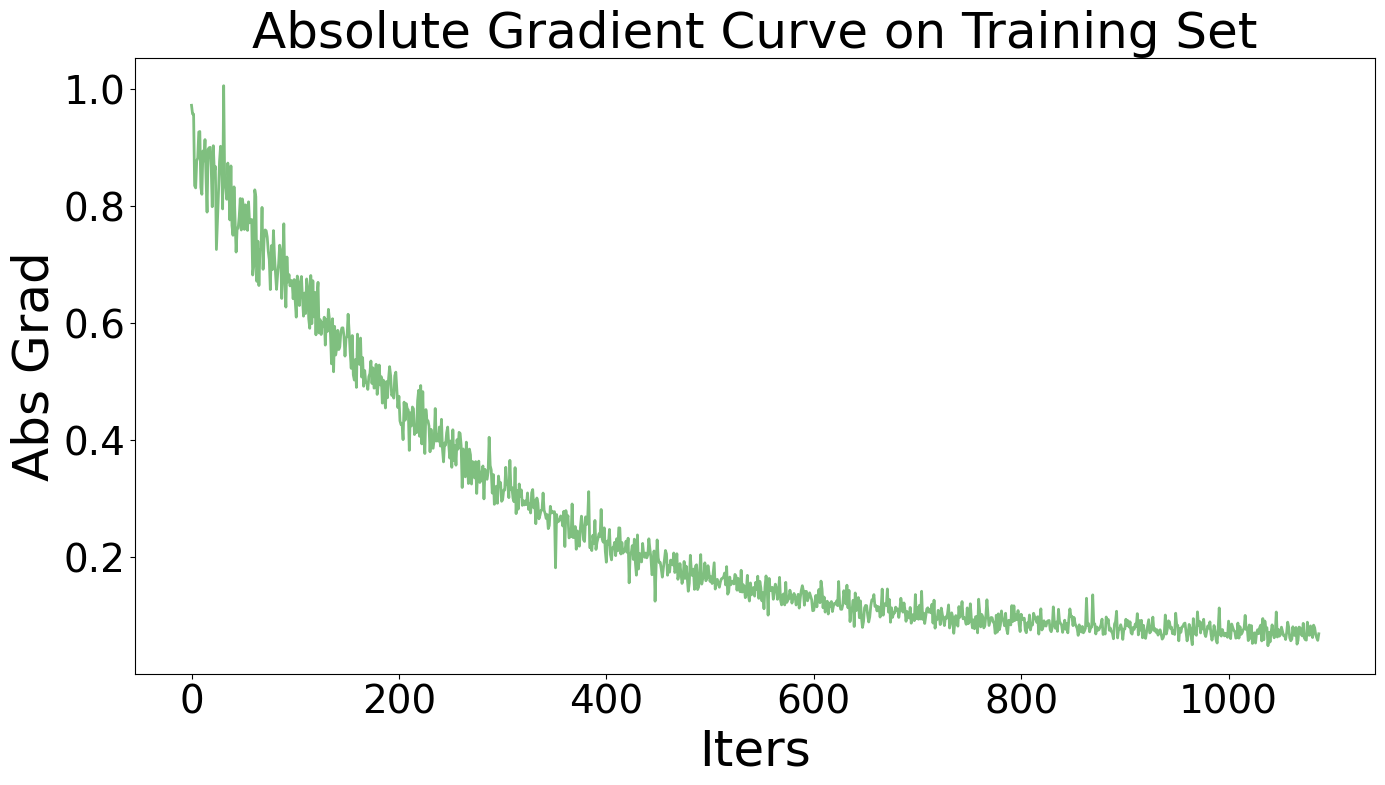

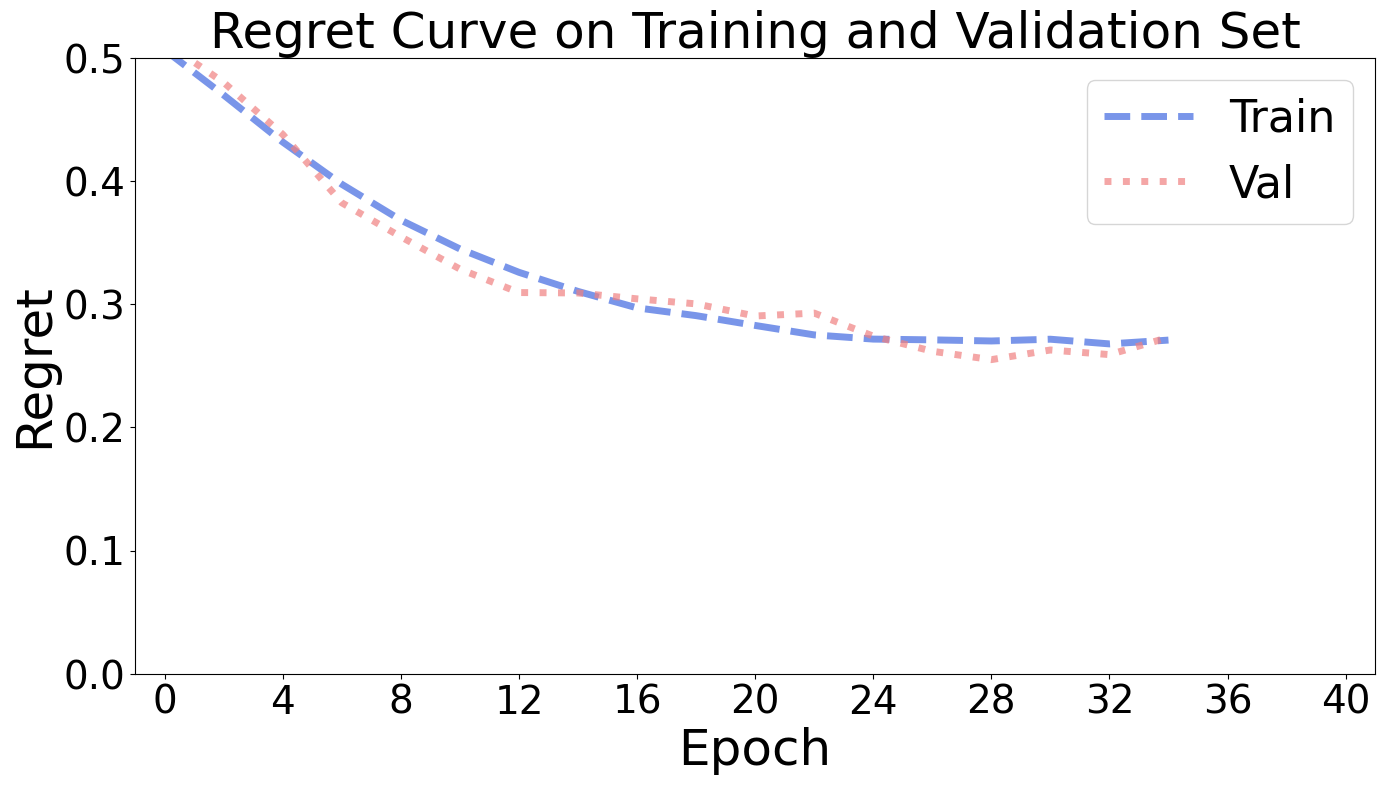

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [22]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  52.5283%, Val Regret:  54.9013%


Epoch    1, Loss:  -0.7909:   5%|██▊                                                    | 2/40 [00:09<01:39,  2.61s/it]

Epoch   2, Train Regret:  49.6230%, Val Regret:  52.3826%


Epoch    3, Loss:  -0.8612:  10%|█████▌                                                 | 4/40 [00:14<01:32,  2.56s/it]

Epoch   4, Train Regret:  45.6649%, Val Regret:  45.8816%


Epoch    5, Loss:  -0.8795:  15%|████████▎                                              | 6/40 [00:20<01:25,  2.52s/it]

Epoch   6, Train Regret:  42.1292%, Val Regret:  43.8734%


Epoch    7, Loss:  -0.9457:  20%|███████████                                            | 8/40 [00:25<01:19,  2.49s/it]

Epoch   8, Train Regret:  38.6618%, Val Regret:  39.2444%


Epoch    9, Loss:  -0.9416:  25%|█████████████▌                                        | 10/40 [00:30<01:12,  2.42s/it]

Epoch  10, Train Regret:  35.9353%, Val Regret:  34.8536%


Epoch   11, Loss:  -0.9384:  30%|████████████████▏                                     | 12/40 [00:35<01:06,  2.38s/it]

Epoch  12, Train Regret:  33.6052%, Val Regret:  32.4370%


Epoch   13, Loss:  -0.9635:  35%|██████████████████▉                                   | 14/40 [00:40<01:00,  2.32s/it]

Epoch  14, Train Regret:  31.9219%, Val Regret:  32.7774%


Epoch   15, Loss:  -0.9662:  40%|█████████████████████▌                                | 16/40 [00:45<00:54,  2.27s/it]

Epoch  16, Train Regret:  30.5148%, Val Regret:  31.0756%


Epoch   17, Loss:  -0.9805:  45%|████████████████████████▎                             | 18/40 [00:49<00:48,  2.20s/it]

Epoch  18, Train Regret:  29.2181%, Val Regret:  31.6201%


Epoch   19, Loss:  -0.9785:  50%|███████████████████████████                           | 20/40 [00:54<00:43,  2.17s/it]

Epoch  20, Train Regret:  28.0352%, Val Regret:  29.8162%


Epoch   21, Loss:  -0.9916:  55%|█████████████████████████████▋                        | 22/40 [00:58<00:38,  2.13s/it]

Epoch  22, Train Regret:  27.3040%, Val Regret:  30.5650%


Epoch   23, Loss:  -0.9813:  60%|████████████████████████████████▍                     | 24/40 [01:03<00:33,  2.09s/it]

Epoch  24, Train Regret:  27.0213%, Val Regret:  29.3057%


Epoch   25, Loss:  -0.9838:  65%|███████████████████████████████████                   | 26/40 [01:07<00:28,  2.04s/it]

Epoch  26, Train Regret:  27.4438%, Val Regret:  28.6590%


Epoch   27, Loss:  -0.9833:  70%|█████████████████████████████████████▊                | 28/40 [01:11<00:23,  1.98s/it]

Epoch  28, Train Regret:  26.9238%, Val Regret:  29.3397%


Epoch   29, Loss:  -0.9943:  75%|████████████████████████████████████████▌             | 30/40 [01:15<00:19,  1.94s/it]

Epoch  30, Train Regret:  26.8946%, Val Regret:  30.2246%


Epoch   31, Loss:  -0.9921:  80%|███████████████████████████████████████████▏          | 32/40 [01:19<00:19,  2.49s/it]


Epoch  32, Train Regret:  26.3746%, Val Regret:  29.0674%

Early Stop!
Training Elapsed Time: 5.88 Sec

Evaluation:
Test Regret: 26.0581%
Test Elapsed Time: 1.65 Sec


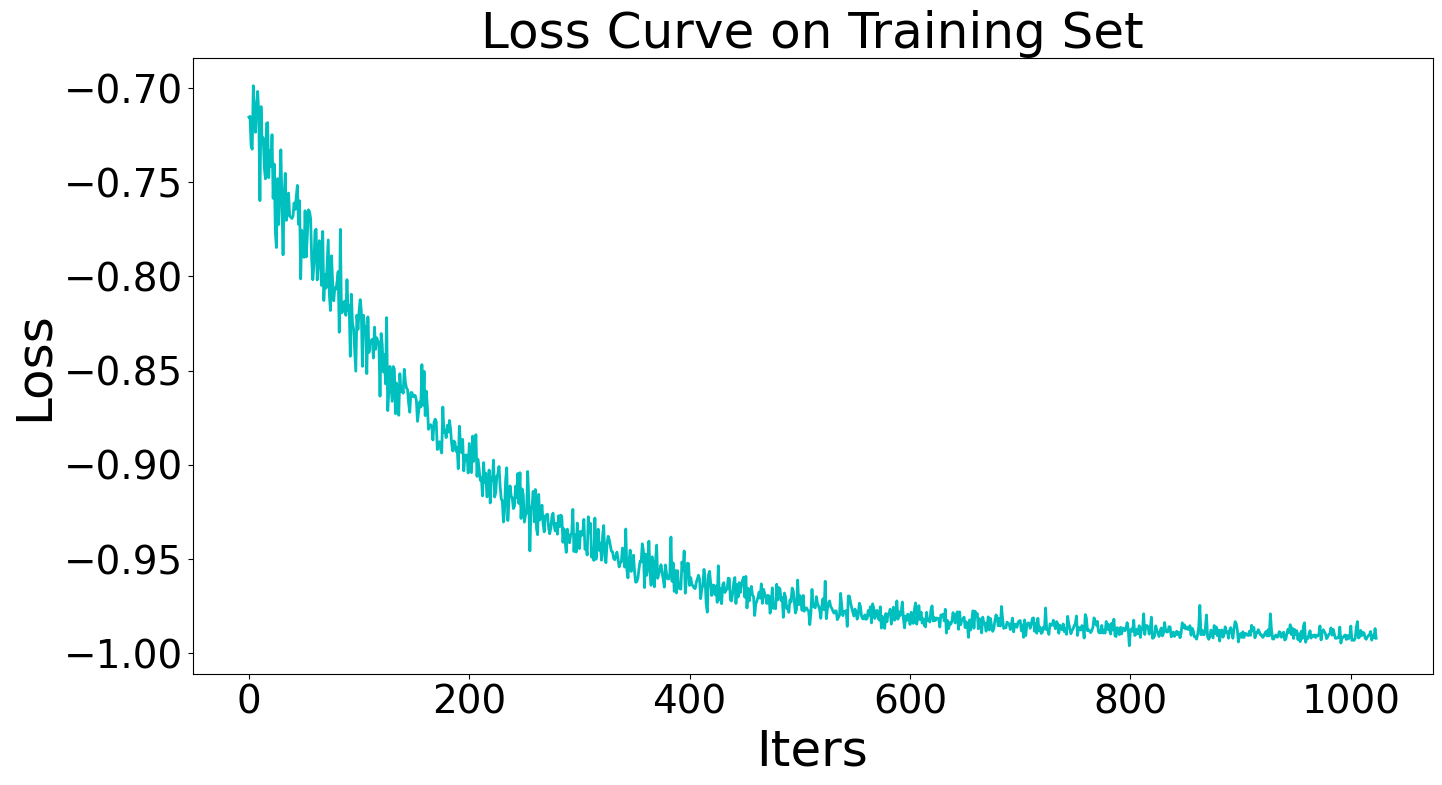

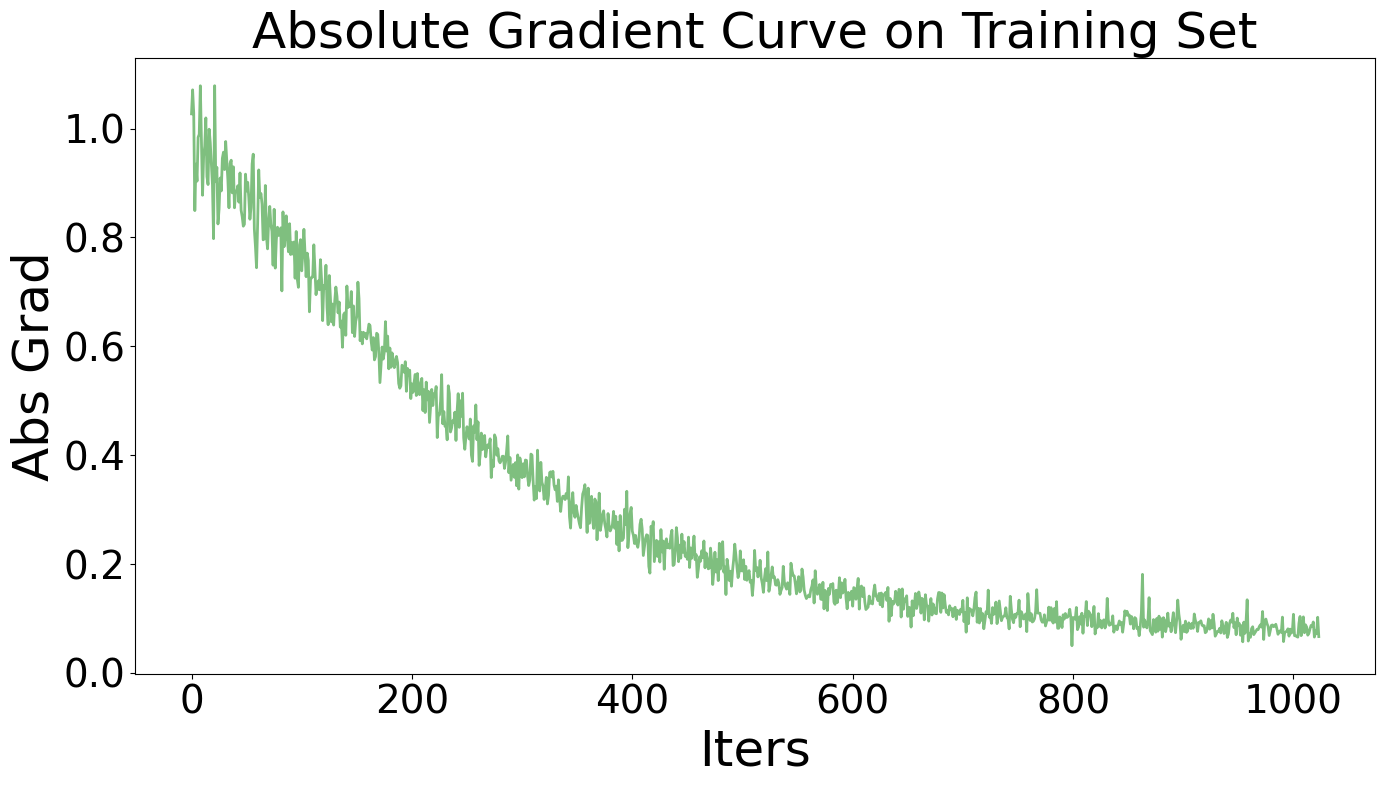

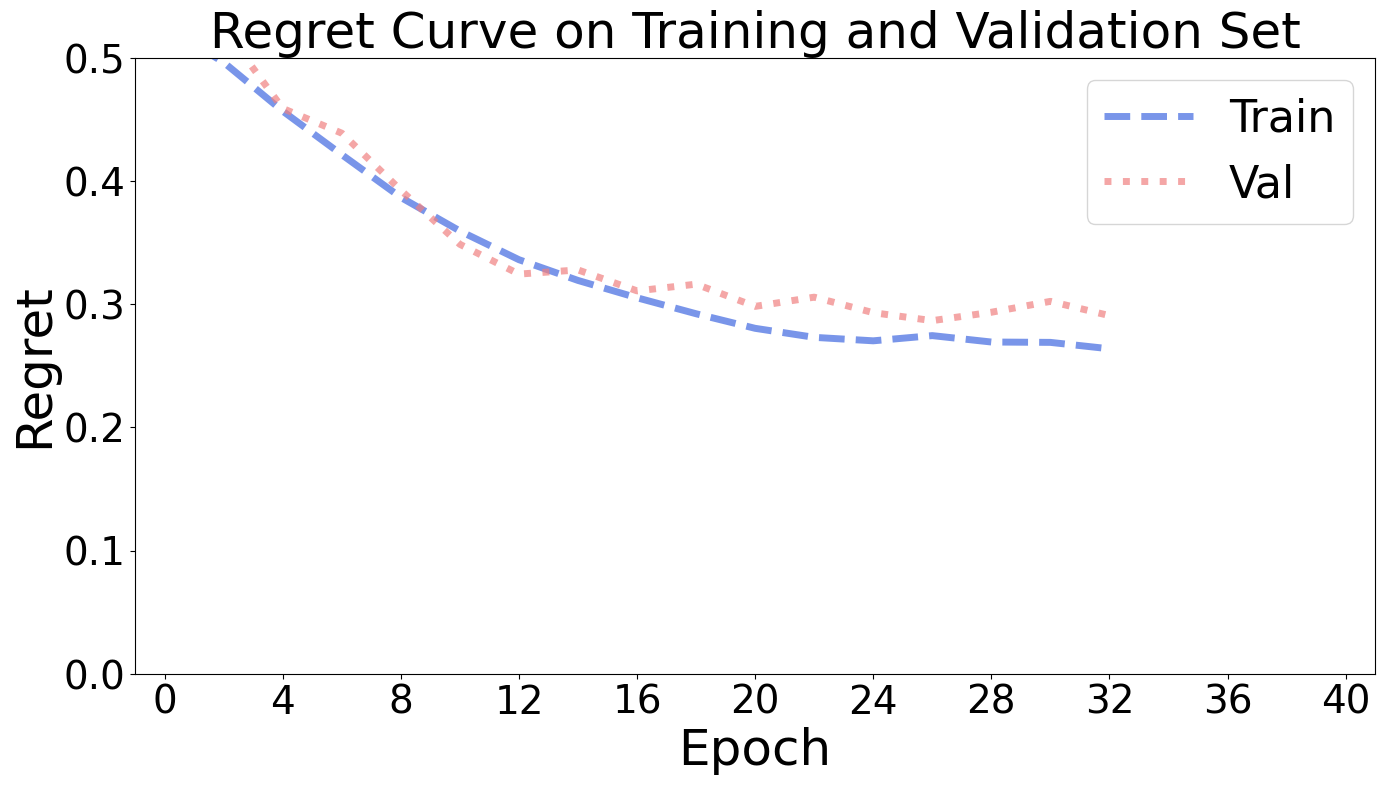

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with NNLS

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [26]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  52.7070%, Val Regret:  54.2886%


Epoch    1, Loss:  -0.8212:   5%|██▊                                                    | 2/40 [00:08<01:33,  2.47s/it]

Epoch   2, Train Regret:  48.7781%, Val Regret:  51.7699%


Epoch    3, Loss:  -0.8836:  10%|█████▌                                                 | 4/40 [00:13<01:28,  2.45s/it]

Epoch   4, Train Regret:  45.1384%, Val Regret:  46.5623%


Epoch    5, Loss:  -0.8929:  15%|████████▎                                              | 6/40 [00:19<01:22,  2.44s/it]

Epoch   6, Train Regret:  42.3469%, Val Regret:  42.5119%


Epoch    7, Loss:  -0.9298:  20%|███████████                                            | 8/40 [00:24<01:16,  2.40s/it]

Epoch   8, Train Regret:  39.8869%, Val Regret:  40.4697%


Epoch    9, Loss:  -0.9511:  25%|█████████████▌                                        | 10/40 [00:29<01:10,  2.33s/it]

Epoch  10, Train Regret:  37.7031%, Val Regret:  39.4486%


Epoch   11, Loss:  -0.9488:  30%|████████████████▏                                     | 12/40 [00:33<01:04,  2.29s/it]

Epoch  12, Train Regret:  36.2082%, Val Regret:  38.5977%


Epoch   13, Loss:  -0.9822:  35%|██████████████████▉                                   | 14/40 [00:38<00:57,  2.23s/it]

Epoch  14, Train Regret:  34.2909%, Val Regret:  35.2621%


Epoch   15, Loss:  -0.9704:  40%|█████████████████████▌                                | 16/40 [00:43<00:52,  2.19s/it]

Epoch  16, Train Regret:  32.8903%, Val Regret:  34.4792%


Epoch   17, Loss:  -0.9762:  45%|████████████████████████▎                             | 18/40 [00:47<00:46,  2.13s/it]

Epoch  18, Train Regret:  32.4581%, Val Regret:  32.6072%


Epoch   19, Loss:  -0.9748:  50%|███████████████████████████                           | 20/40 [00:51<00:41,  2.06s/it]

Epoch  20, Train Regret:  31.9121%, Val Regret:  31.9265%


Epoch   21, Loss:  -0.9897:  55%|█████████████████████████████▋                        | 22/40 [00:55<00:35,  1.99s/it]

Epoch  22, Train Regret:  31.5742%, Val Regret:  31.9265%


Epoch   23, Loss:  -0.9859:  60%|████████████████████████████████▍                     | 24/40 [00:59<00:30,  1.92s/it]

Epoch  24, Train Regret:  33.4102%, Val Regret:  32.1647%


Epoch   25, Loss:  -0.9876:  65%|███████████████████████████████████                   | 26/40 [01:03<00:34,  2.45s/it]


Epoch  26, Train Regret:  34.9376%, Val Regret:  34.9898%

Early Stop!
Training Elapsed Time: 5.08 Sec

Evaluation:
Test Regret: 31.5669%
Test Elapsed Time: 1.68 Sec


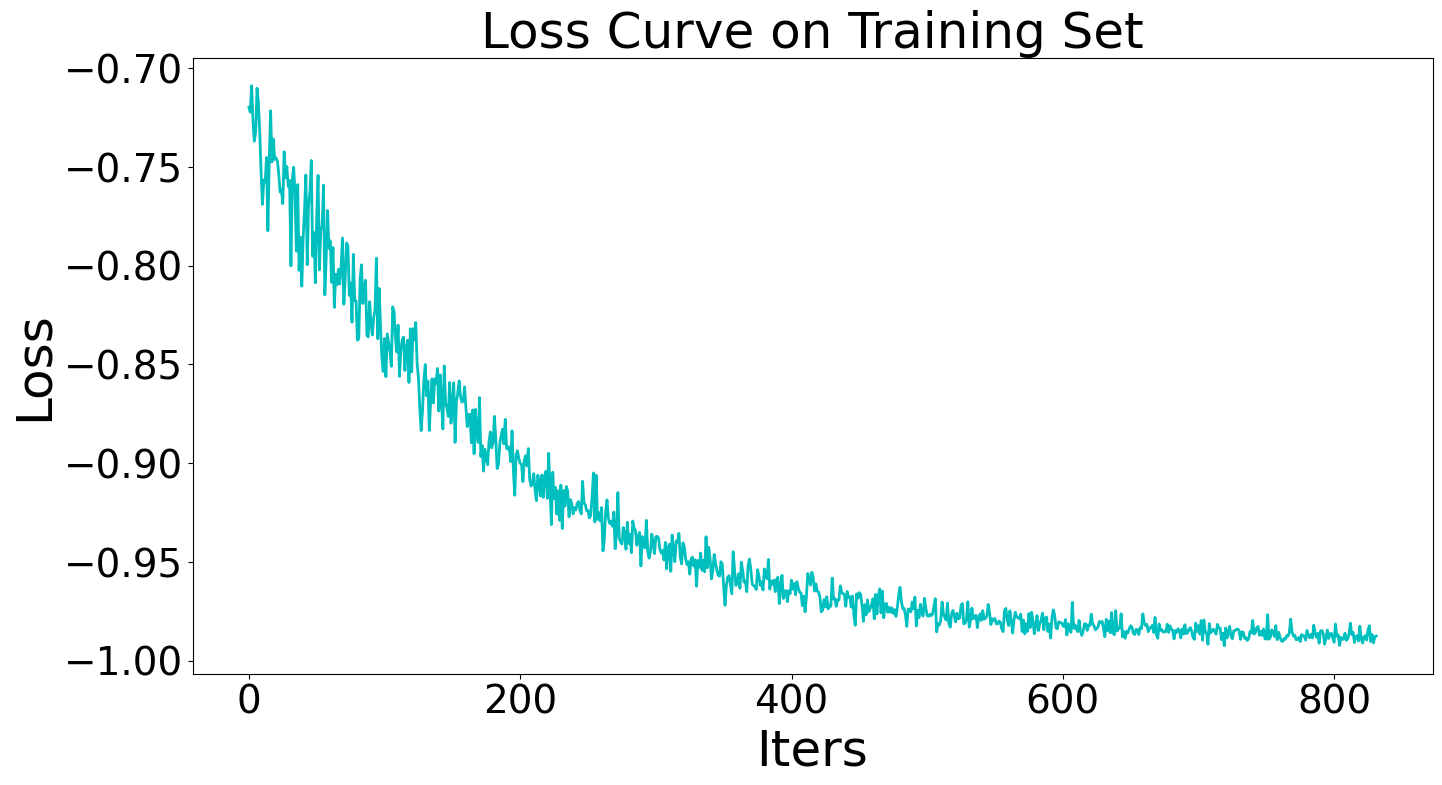

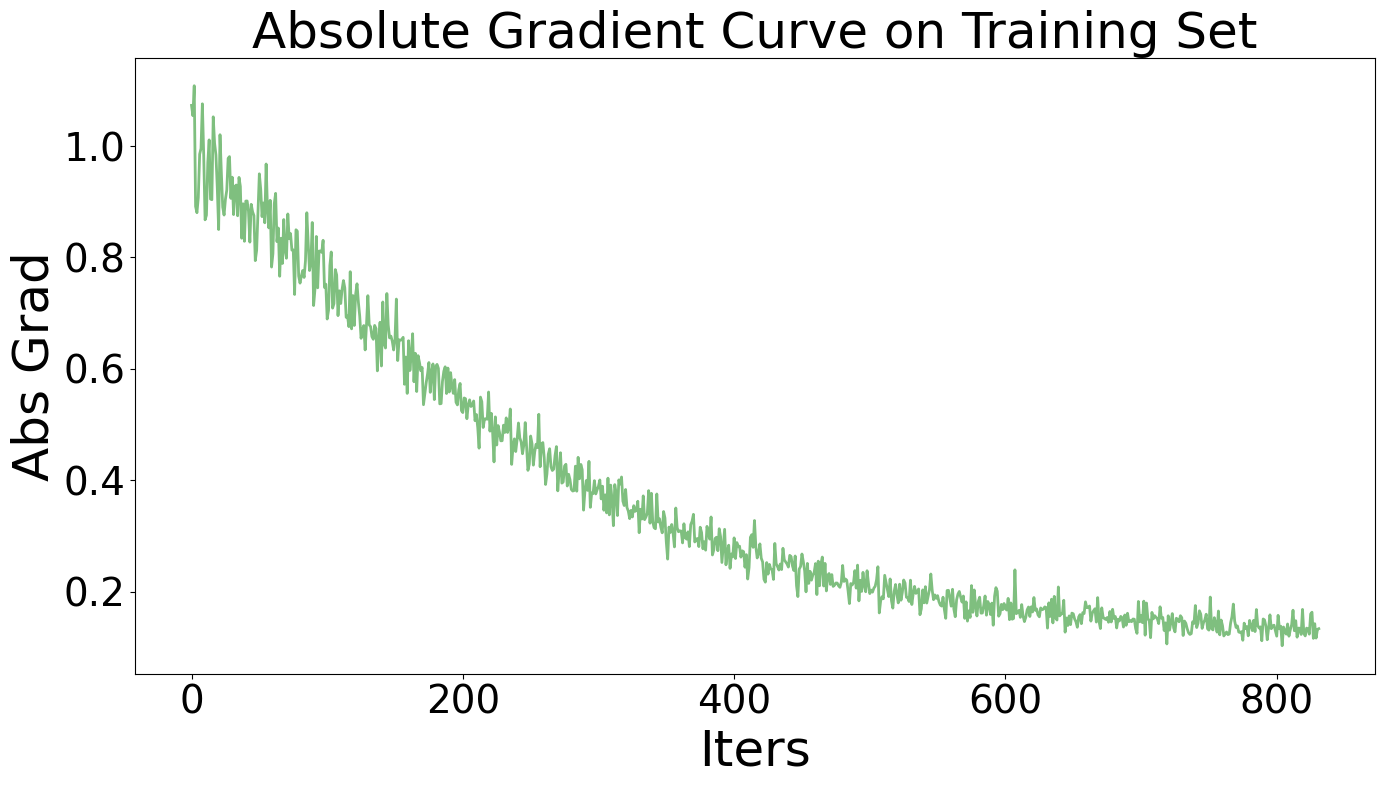

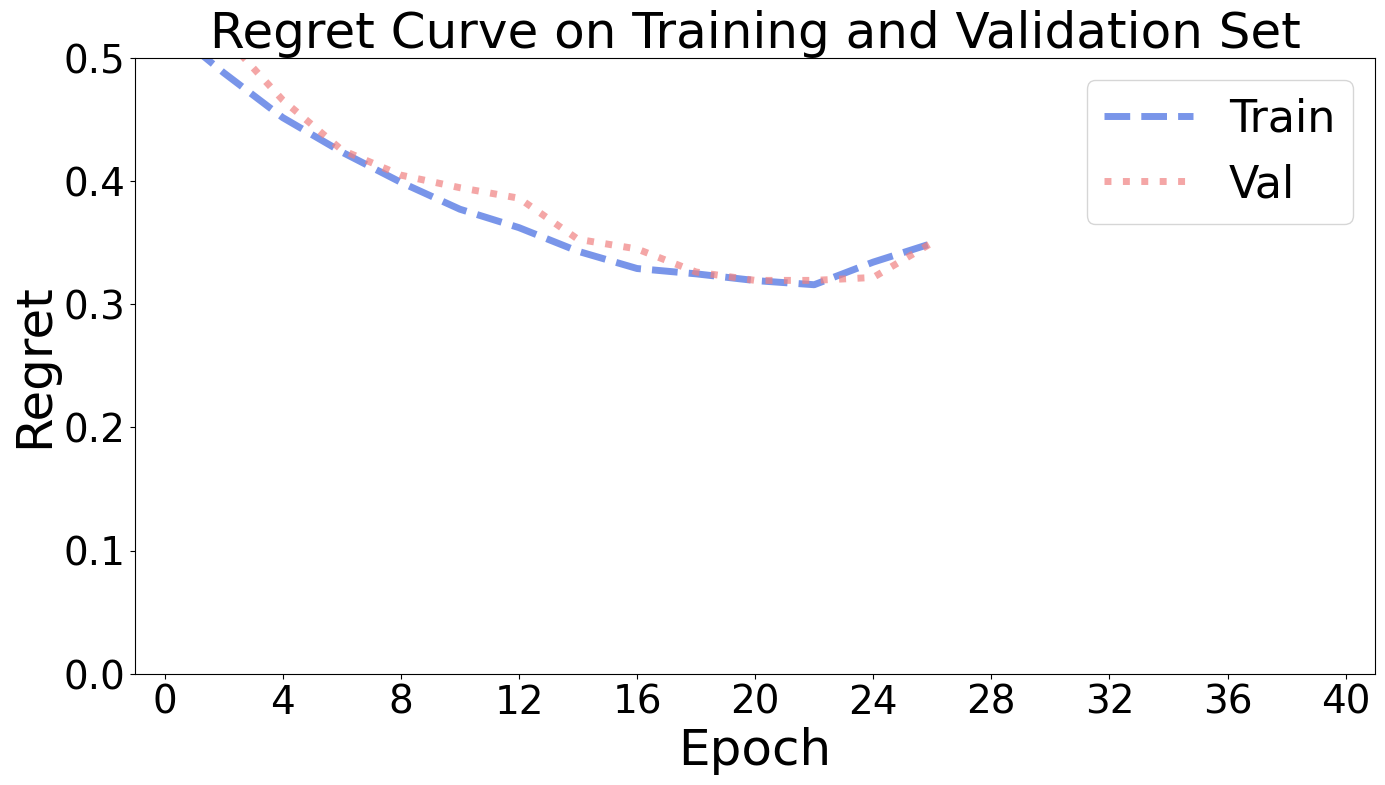

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", solve_ratio=0.1, processes=1)

Num of cores: 1


In [30]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  54.1434%, Val Regret:  54.2886%


Epoch    1, Loss:  -0.9991:   5%|██▊                                                    | 2/40 [00:08<01:31,  2.40s/it]

Epoch   2, Train Regret:  51.7808%, Val Regret:  52.5187%


Epoch    3, Loss:  -0.9991:  10%|█████▌                                                 | 4/40 [00:13<01:25,  2.37s/it]

Epoch   4, Train Regret:  50.3185%, Val Regret:  50.3404%


Epoch    5, Loss:  -0.9991:  15%|████████▎                                              | 6/40 [00:18<01:20,  2.35s/it]

Epoch   6, Train Regret:  48.8789%, Val Regret:  48.4343%


Epoch    7, Loss:  -0.9992:  20%|███████████                                            | 8/40 [00:24<01:14,  2.34s/it]

Epoch   8, Train Regret:  47.7155%, Val Regret:  47.1409%


Epoch    9, Loss:  -0.9991:  25%|█████████████▌                                        | 10/40 [00:29<01:11,  2.38s/it]

Epoch  10, Train Regret:  45.7039%, Val Regret:  46.3581%


Epoch   11, Loss:  -0.9992:  30%|████████████████▏                                     | 12/40 [00:34<01:06,  2.39s/it]

Epoch  12, Train Regret:  43.2634%, Val Regret:  43.1586%


Epoch   13, Loss:  -0.9993:  35%|██████████████████▉                                   | 14/40 [00:39<01:02,  2.39s/it]

Epoch  14, Train Regret:  41.0536%, Val Regret:  41.5589%


Epoch   15, Loss:  -0.9993:  40%|█████████████████████▌                                | 16/40 [00:44<00:55,  2.31s/it]

Epoch  16, Train Regret:  38.5805%, Val Regret:  40.3676%


Epoch   17, Loss:  -0.9992:  45%|████████████████████████▎                             | 18/40 [00:49<00:49,  2.26s/it]

Epoch  18, Train Regret:  37.1084%, Val Regret:  38.5636%


Epoch   19, Loss:  -0.9993:  50%|███████████████████████████                           | 20/40 [00:54<00:44,  2.21s/it]

Epoch  20, Train Regret:  35.7013%, Val Regret:  35.4663%


Epoch   21, Loss:  -0.9994:  55%|█████████████████████████████▋                        | 22/40 [00:58<00:39,  2.18s/it]

Epoch  22, Train Regret:  34.0732%, Val Regret:  34.6835%


Epoch   23, Loss:  -0.9995:  60%|████████████████████████████████▍                     | 24/40 [01:03<00:33,  2.12s/it]

Epoch  24, Train Regret:  33.1243%, Val Regret:  32.1307%


Epoch   25, Loss:  -0.9994:  65%|███████████████████████████████████                   | 26/40 [01:07<00:28,  2.07s/it]

Epoch  26, Train Regret:  32.0811%, Val Regret:  30.3608%


Epoch   27, Loss:  -0.9995:  70%|█████████████████████████████████████▊                | 28/40 [01:11<00:24,  2.05s/it]

Epoch  28, Train Regret:  31.4539%, Val Regret:  31.0415%


Epoch   29, Loss:  -0.9995:  75%|████████████████████████████████████████▌             | 30/40 [01:15<00:19,  1.98s/it]

Epoch  30, Train Regret:  31.3174%, Val Regret:  32.2668%


Epoch   31, Loss:  -0.9995:  80%|███████████████████████████████████████████▏          | 32/40 [01:19<00:19,  2.50s/it]


Epoch  32, Train Regret:  32.1201%, Val Regret:  32.0626%

Early Stop!
Training Elapsed Time: 3.30 Sec

Evaluation:
Test Regret: 32.3052%
Test Elapsed Time: 1.95 Sec


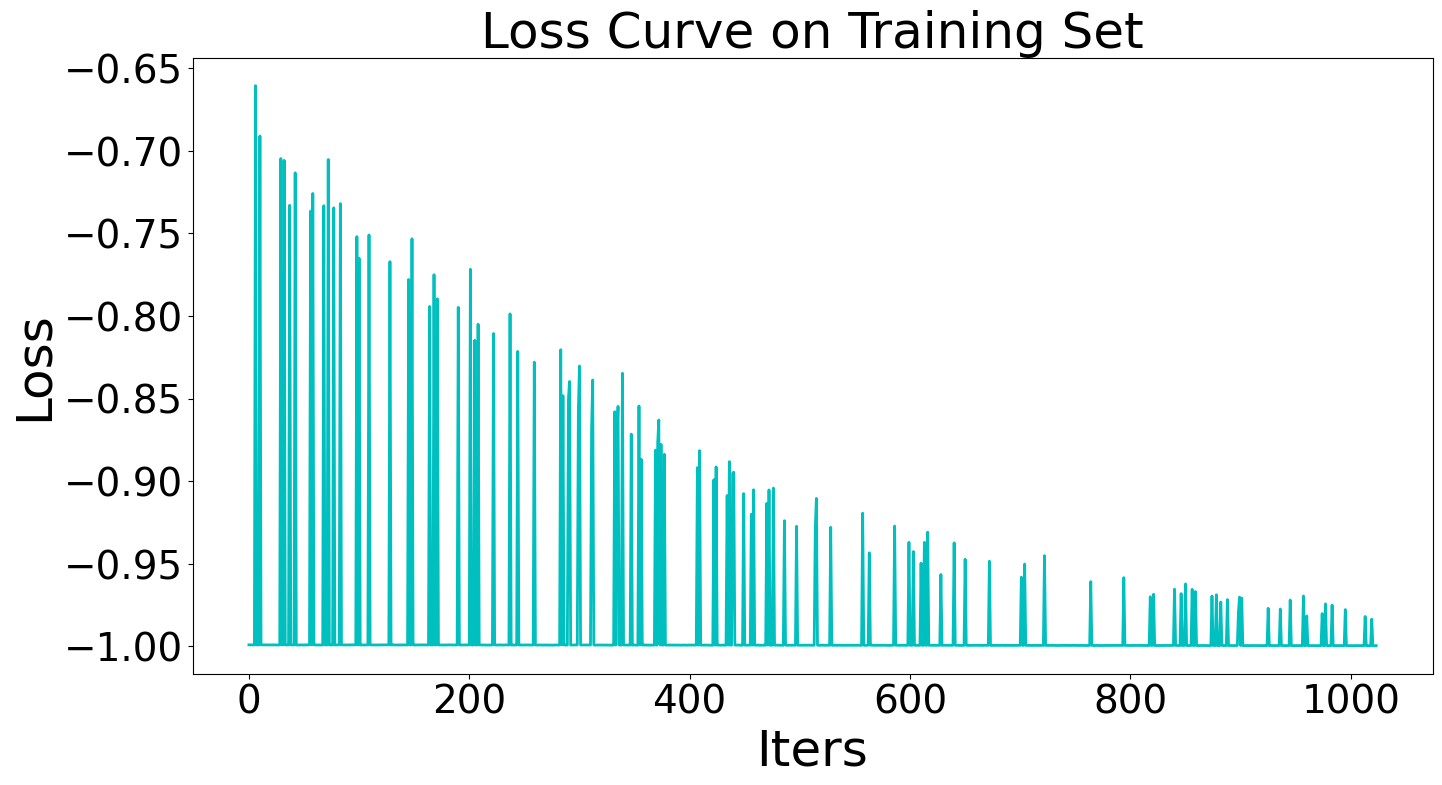

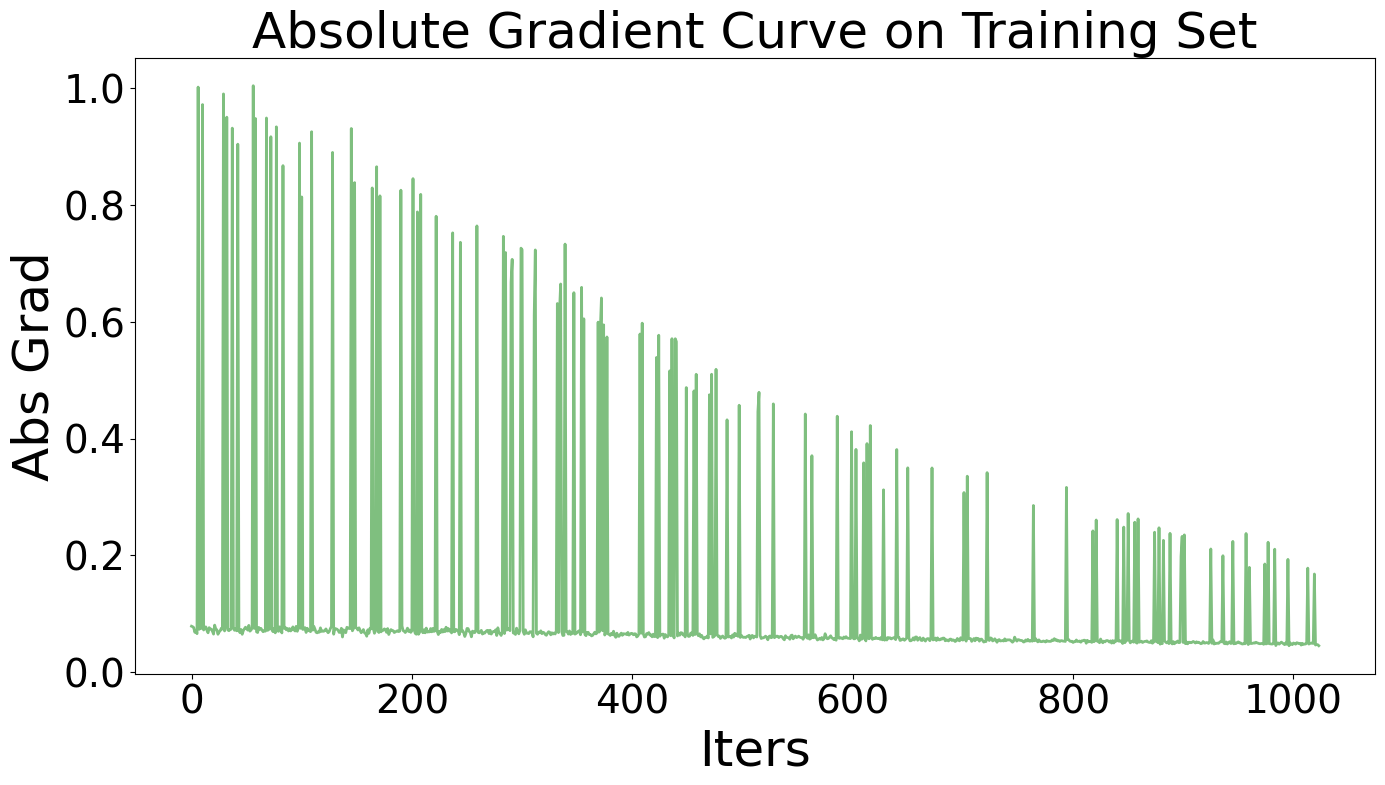

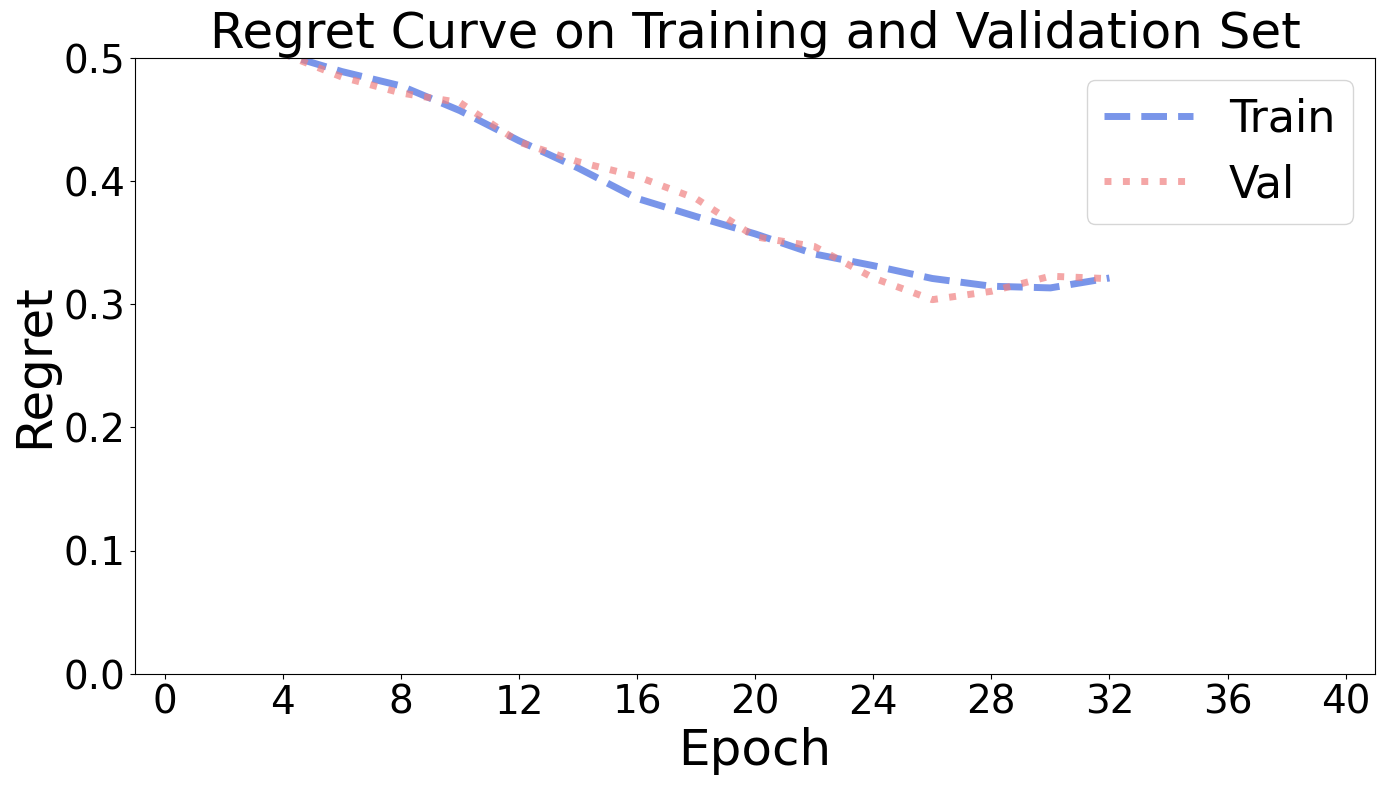

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [34]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  52.7070%, Val Regret:  54.2886%


Epoch    1, Loss:  -0.9971:   5%|██▊                                                    | 2/40 [00:08<01:33,  2.46s/it]

Epoch   2, Train Regret:  48.3556%, Val Regret:  50.8850%


Epoch    3, Loss:  -0.9973:  10%|█████▌                                                 | 4/40 [00:13<01:26,  2.40s/it]

Epoch   4, Train Regret:  43.3608%, Val Regret:  46.6984%


Epoch    5, Loss:  -0.9979:  15%|████████▎                                              | 6/40 [00:18<01:20,  2.36s/it]

Epoch   6, Train Regret:  39.8024%, Val Regret:  42.6140%


Epoch    7, Loss:  -0.9979:  20%|███████████                                            | 8/40 [00:23<01:14,  2.33s/it]

Epoch   8, Train Regret:  36.0815%, Val Regret:  39.4486%


Epoch    9, Loss:  -0.9984:  25%|█████████████▌                                        | 10/40 [00:28<01:07,  2.26s/it]

Epoch  10, Train Regret:  33.2218%, Val Regret:  36.1130%


Epoch   11, Loss:  -0.9987:  30%|████████████████▏                                     | 12/40 [00:32<01:01,  2.19s/it]

Epoch  12, Train Regret:  32.3476%, Val Regret:  32.3009%


Epoch   13, Loss:  -0.9987:  35%|██████████████████▉                                   | 14/40 [00:36<00:54,  2.08s/it]

Epoch  14, Train Regret:  33.5305%, Val Regret:  34.1389%


Epoch   15, Loss:  -0.9989:  40%|█████████████████████▌                                | 16/40 [00:40<00:47,  1.97s/it]

Epoch  16, Train Regret:  37.5796%, Val Regret:  38.8359%


Epoch   17, Loss:  -0.9989:  45%|████████████████████████▎                             | 18/40 [00:44<00:53,  2.45s/it]


Epoch  18, Train Regret:  43.6956%, Val Regret:  44.1116%

Early Stop!
Training Elapsed Time: 2.49 Sec

Evaluation:
Test Regret: 31.4043%
Test Elapsed Time: 1.79 Sec


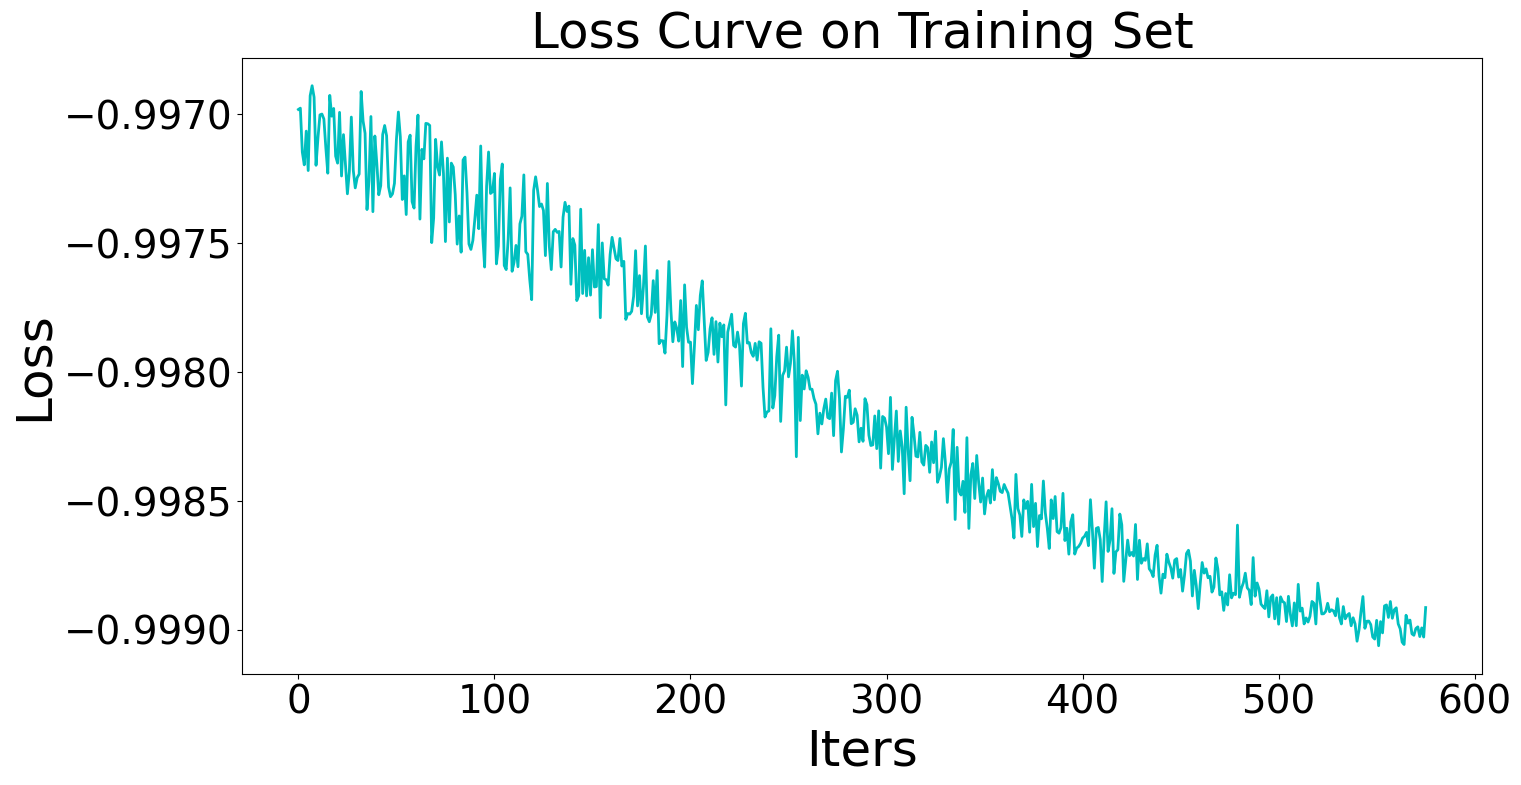

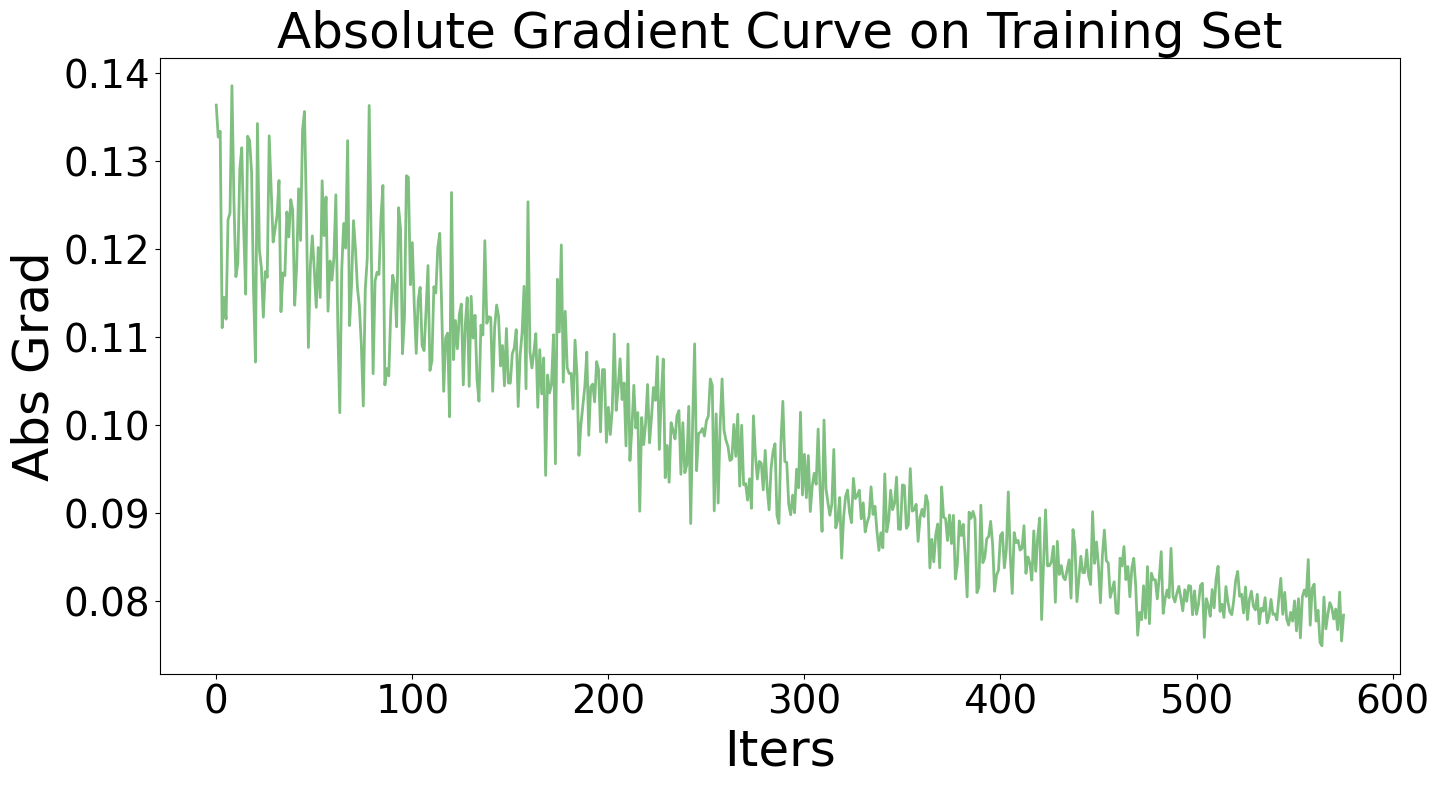

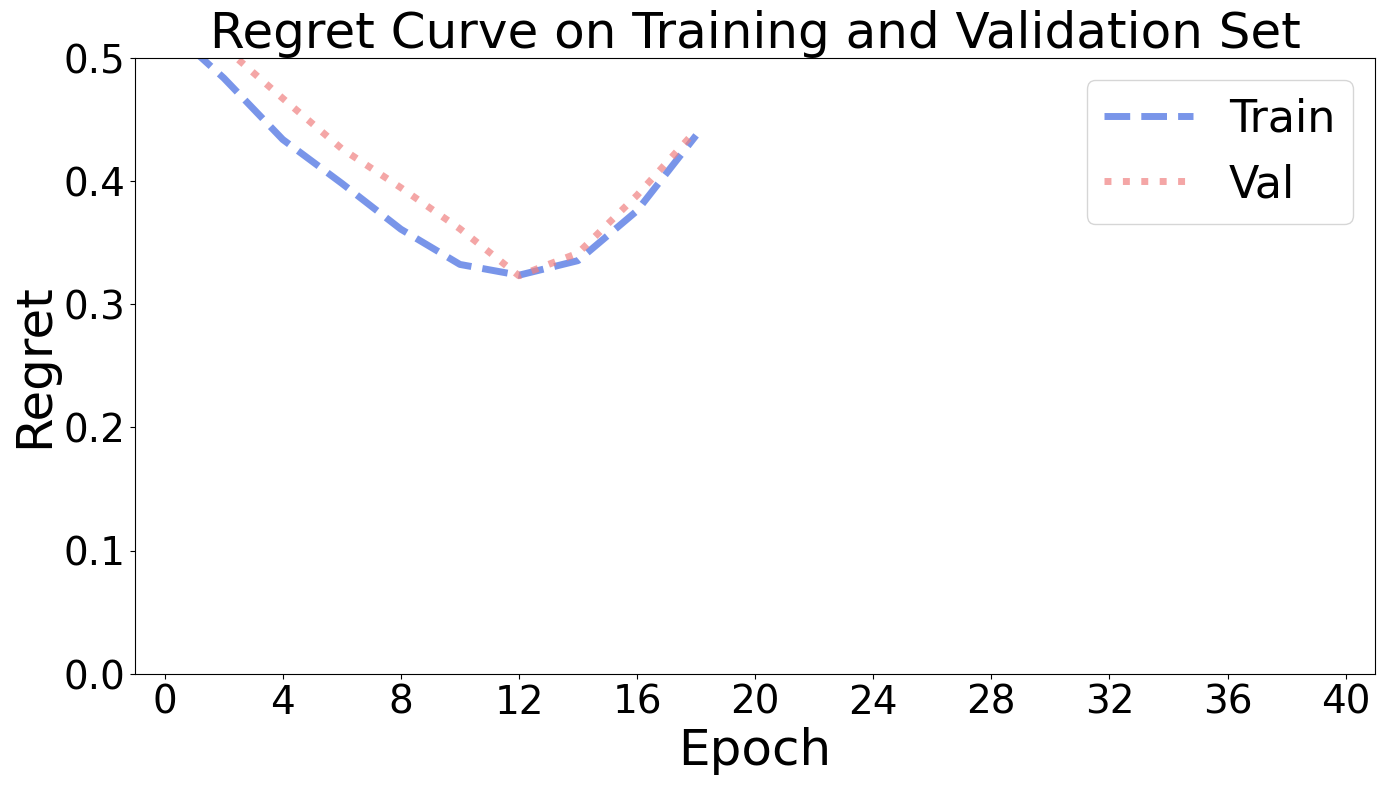

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [38]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  44.3975%, Val Regret:  47.8897%


Epoch    1, Loss:  -0.9973:   5%|██▊                                                    | 2/40 [00:11<02:19,  3.66s/it]

Epoch   2, Train Regret:  40.5986%, Val Regret:  42.2396%


Epoch    3, Loss:  -0.9976:  10%|█████▌                                                 | 4/40 [00:19<02:11,  3.65s/it]

Epoch   4, Train Regret:  37.1019%, Val Regret:  38.6317%


Epoch    5, Loss:  -0.9974:  15%|████████▎                                              | 6/40 [00:27<02:07,  3.75s/it]

Epoch   6, Train Regret:  34.0829%, Val Regret:  35.1259%


Epoch    7, Loss:  -0.9976:  20%|███████████                                            | 8/40 [00:34<01:57,  3.66s/it]

Epoch   8, Train Regret:  31.0867%, Val Regret:  32.3690%


Epoch    9, Loss:  -0.9980:  25%|█████████████▌                                        | 10/40 [00:41<01:44,  3.47s/it]

Epoch  10, Train Regret:  29.1336%, Val Regret:  31.5861%


Epoch   11, Loss:  -0.9982:  30%|████████████████▏                                     | 12/40 [00:47<01:33,  3.35s/it]

Epoch  12, Train Regret:  27.8565%, Val Regret:  28.0463%


Epoch   13, Loss:  -0.9988:  35%|██████████████████▉                                   | 14/40 [00:54<01:23,  3.22s/it]

Epoch  14, Train Regret:  27.5153%, Val Regret:  28.5228%


Epoch   15, Loss:  -0.9989:  40%|█████████████████████▌                                | 16/40 [01:00<01:14,  3.10s/it]

Epoch  16, Train Regret:  29.7381%, Val Regret:  30.0545%


Epoch   17, Loss:  -0.9987:  45%|████████████████████████▎                             | 18/40 [01:06<01:20,  3.68s/it]


Epoch  18, Train Regret:  34.7589%, Val Regret:  33.9006%

Early Stop!
Training Elapsed Time: 22.57 Sec

Evaluation:
Test Regret: 28.0508%
Test Elapsed Time: 1.99 Sec


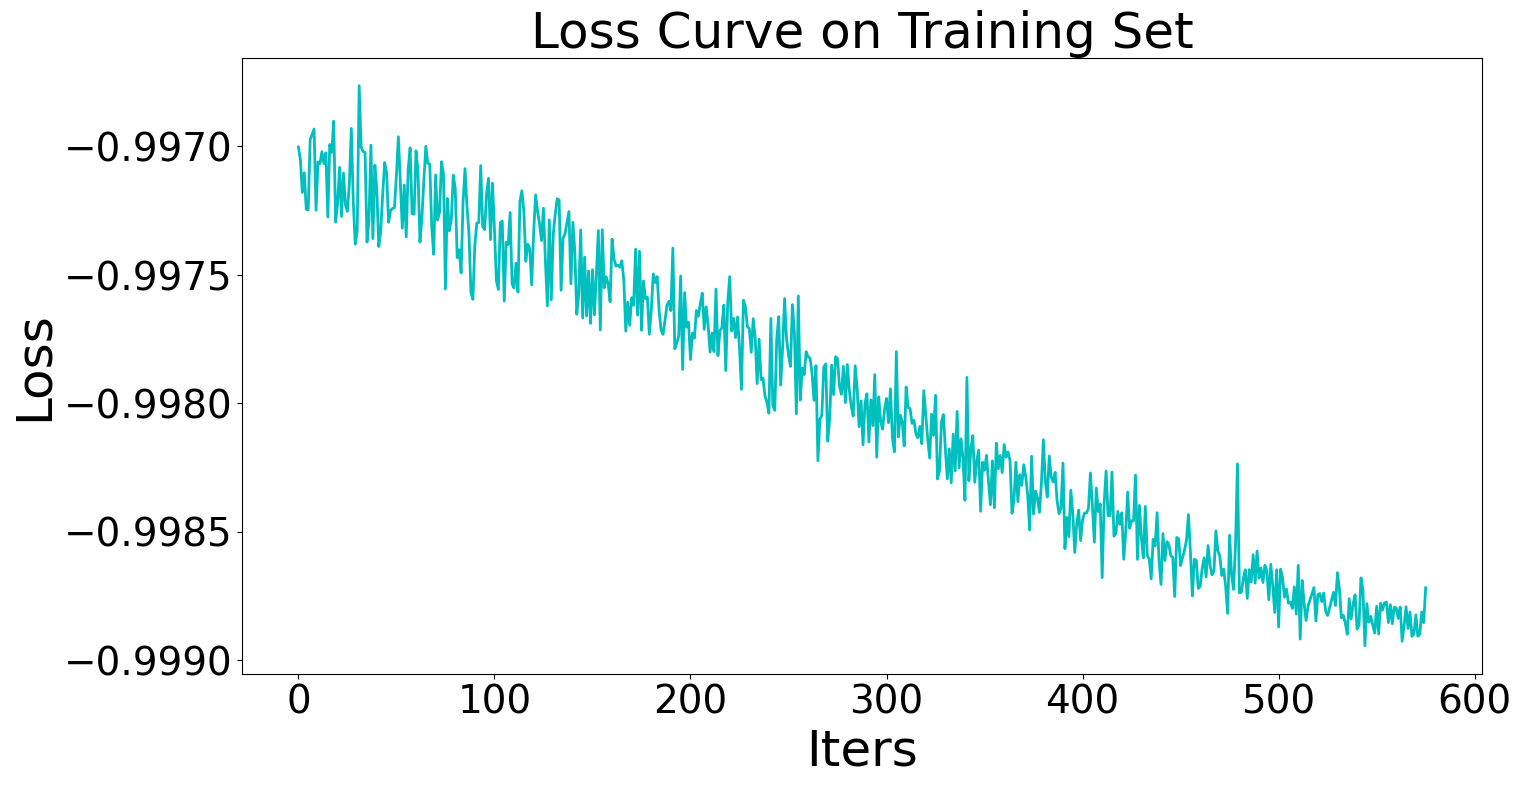

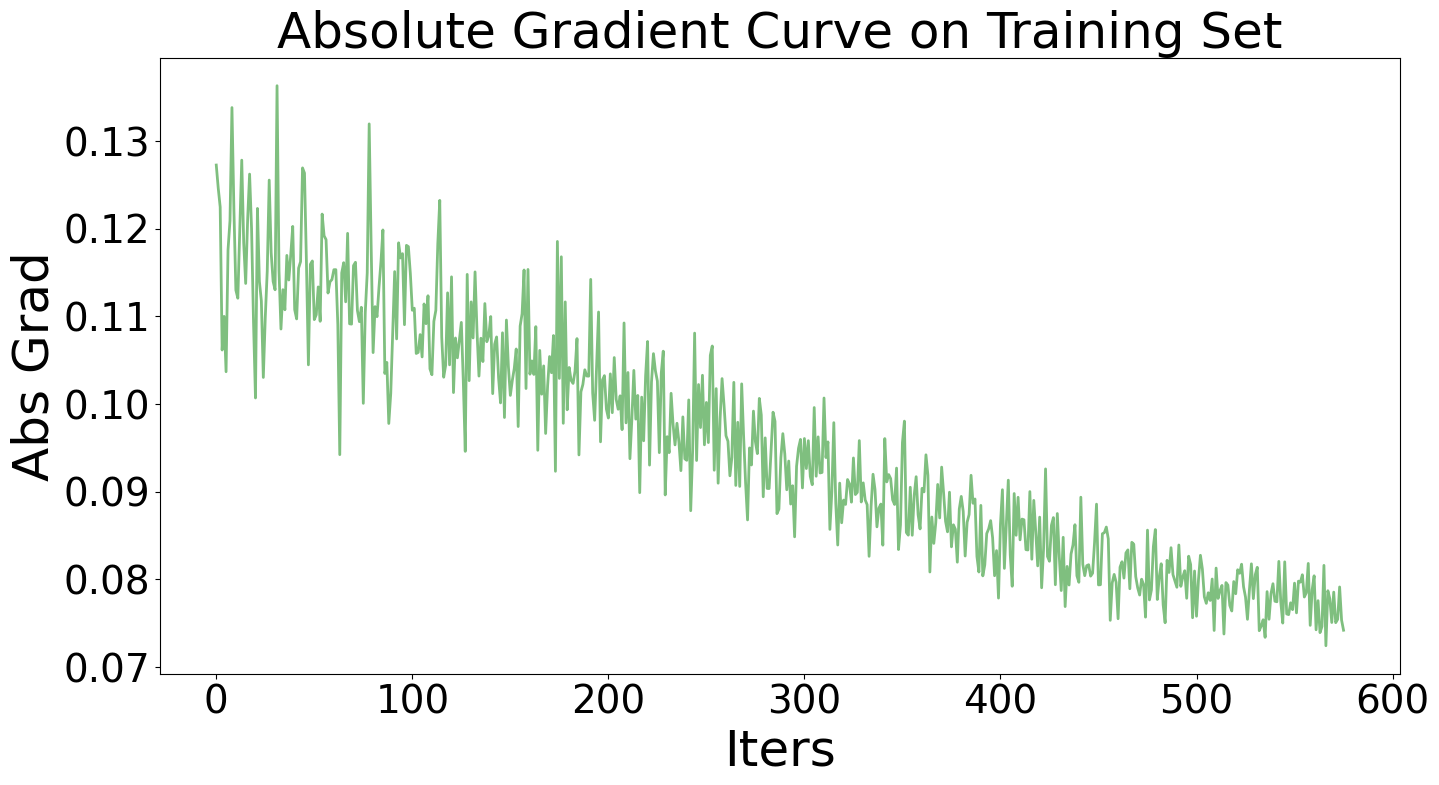

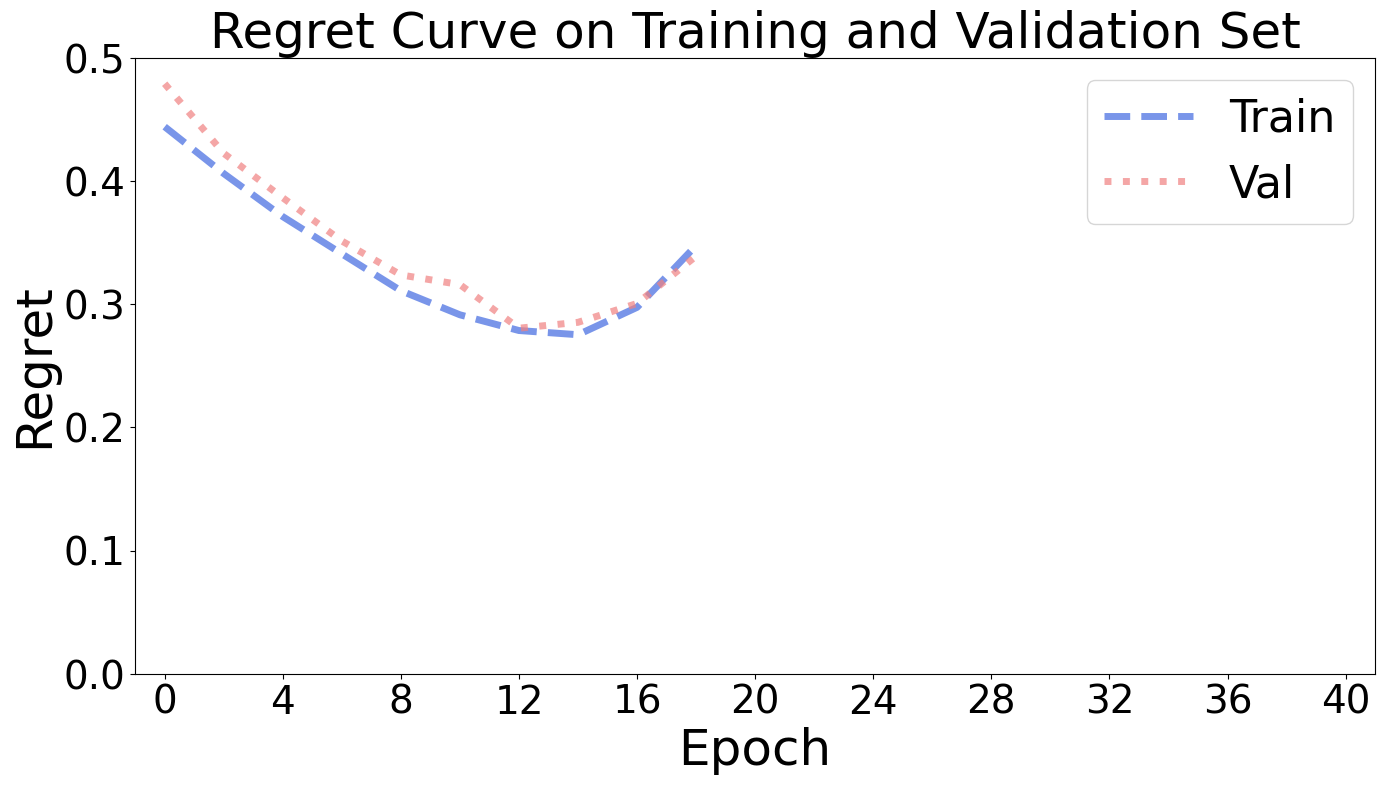

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [42]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  44.3975%, Val Regret:  47.8897%


Epoch    1, Loss:  -0.9973:   5%|██▊                                                    | 2/40 [00:08<01:35,  2.50s/it]

Epoch   2, Train Regret:  40.3679%, Val Regret:  41.3206%


Epoch    3, Loss:  -0.9976:  10%|█████▌                                                 | 4/40 [00:13<01:27,  2.43s/it]

Epoch   4, Train Regret:  36.4357%, Val Regret:  38.2914%


Epoch    5, Loss:  -0.9976:  15%|████████▎                                              | 6/40 [00:19<01:21,  2.38s/it]

Epoch   6, Train Regret:  33.5630%, Val Regret:  34.2750%


Epoch    7, Loss:  -0.9982:  20%|███████████                                            | 8/40 [00:23<01:14,  2.32s/it]

Epoch   8, Train Regret:  30.3880%, Val Regret:  31.9265%


Epoch    9, Loss:  -0.9982:  25%|█████████████▌                                        | 10/40 [00:28<01:07,  2.25s/it]

Epoch  10, Train Regret:  28.3504%, Val Regret:  30.9054%


Epoch   11, Loss:  -0.9984:  30%|████████████████▏                                     | 12/40 [00:32<00:59,  2.14s/it]

Epoch  12, Train Regret:  27.2975%, Val Regret:  27.8421%


Epoch   13, Loss:  -0.9988:  35%|██████████████████▉                                   | 14/40 [00:36<00:52,  2.03s/it]

Epoch  14, Train Regret:  28.2270%, Val Regret:  28.5909%


Epoch   15, Loss:  -0.9989:  40%|█████████████████████▌                                | 16/40 [00:40<00:46,  1.92s/it]

Epoch  16, Train Regret:  33.0365%, Val Regret:  32.4370%


Epoch   17, Loss:  -0.9990:  45%|████████████████████████▎                             | 18/40 [00:43<00:53,  2.43s/it]


Epoch  18, Train Regret:  40.2769%, Val Regret:  41.5589%

Early Stop!
Training Elapsed Time: 1.64 Sec

Evaluation:
Test Regret: 27.6097%
Test Elapsed Time: 1.83 Sec


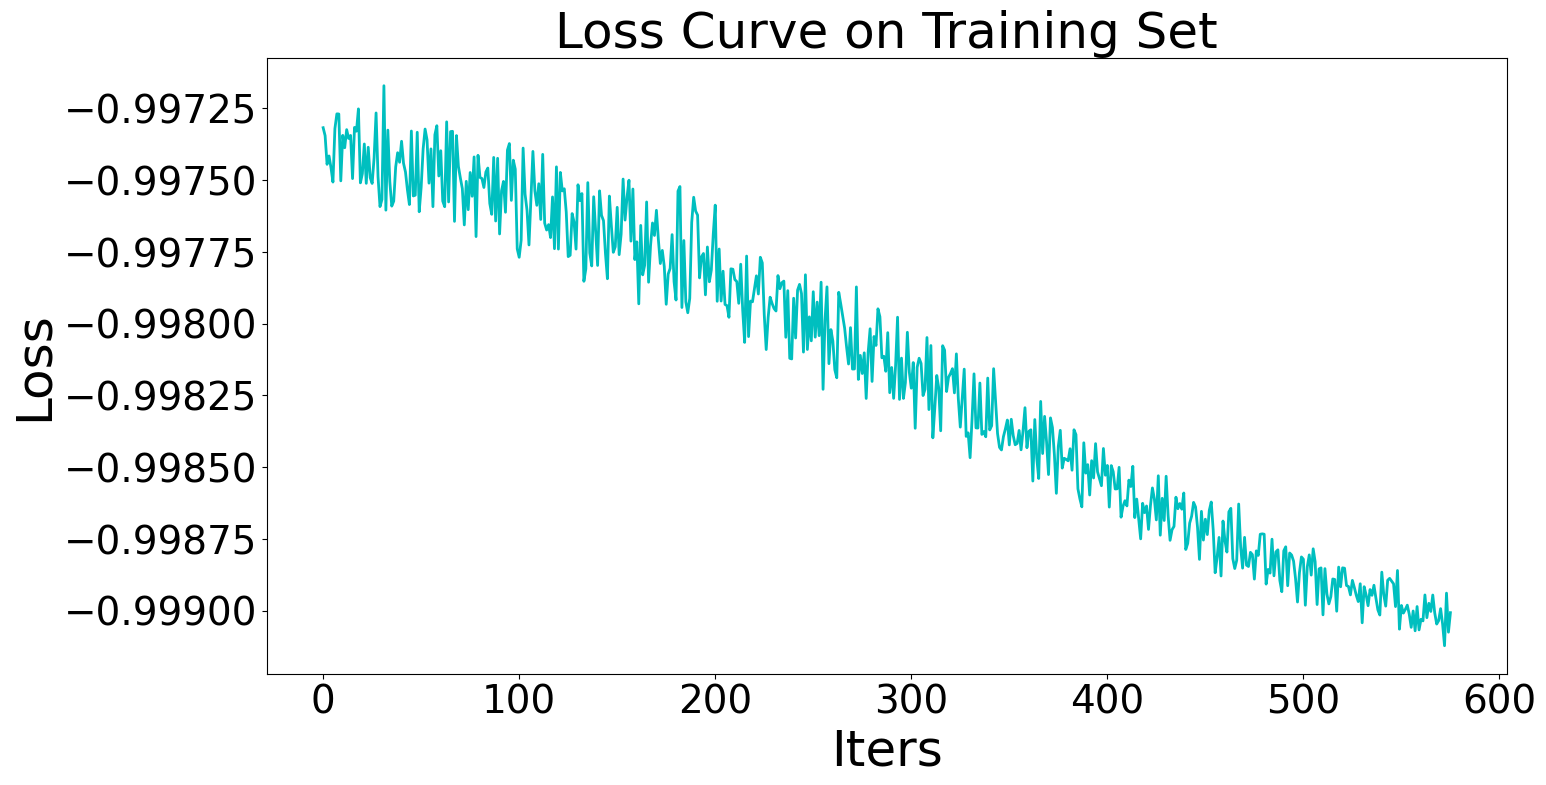

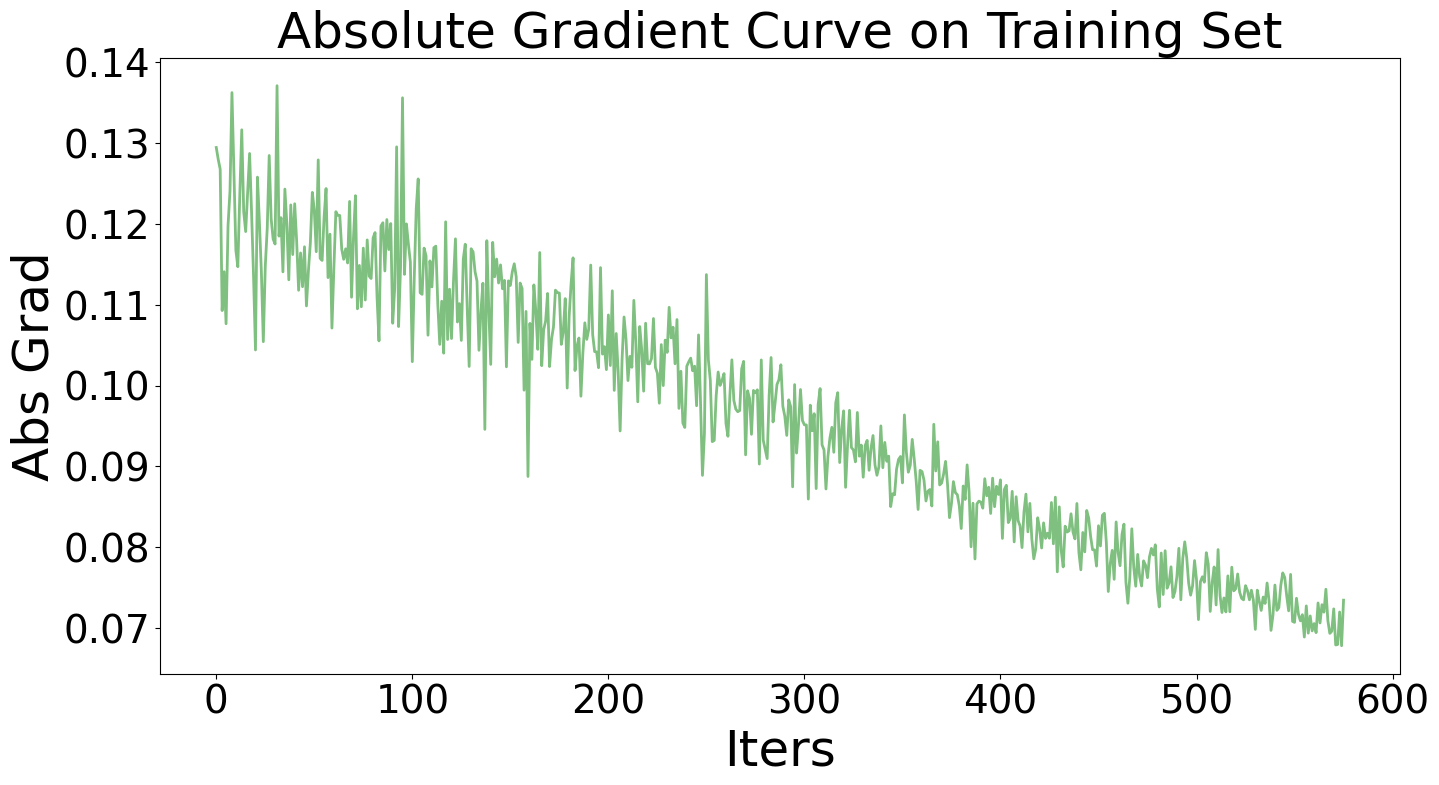

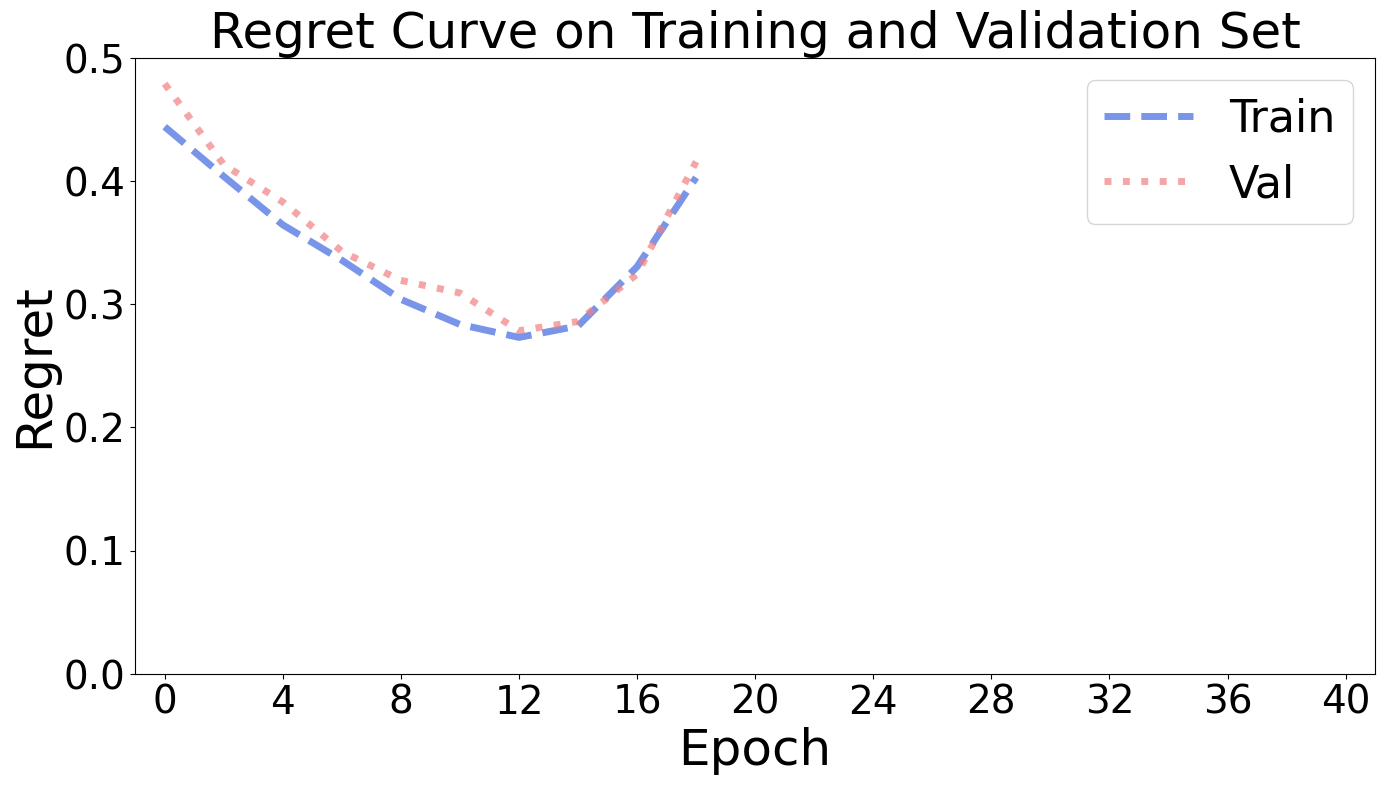

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [46]:
lr = 1e-3
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  57.6076%, Val Regret:  58.1007%


Epoch    1, Loss:  -0.9973:   5%|██▊                                                    | 2/40 [00:10<02:15,  3.57s/it]

Epoch   2, Train Regret:  52.8630%, Val Regret:  52.4847%


Epoch    3, Loss:  -0.9974:  10%|█████▌                                                 | 4/40 [00:18<02:07,  3.54s/it]

Epoch   4, Train Regret:  47.7967%, Val Regret:  47.0388%


Epoch    5, Loss:  -0.9977:  15%|████████▎                                              | 6/40 [00:25<01:59,  3.53s/it]

Epoch   6, Train Regret:  43.0684%, Val Regret:  43.7713%


Epoch    7, Loss:  -0.9982:  20%|███████████                                            | 8/40 [00:33<01:52,  3.53s/it]

Epoch   8, Train Regret:  37.9533%, Val Regret:  39.3465%


Epoch    9, Loss:  -0.9983:  25%|█████████████▌                                        | 10/40 [00:39<01:42,  3.42s/it]

Epoch  10, Train Regret:  35.1618%, Val Regret:  35.4663%


Epoch   11, Loss:  -0.9983:  30%|████████████████▏                                     | 12/40 [00:46<01:31,  3.26s/it]

Epoch  12, Train Regret:  33.0170%, Val Regret:  33.9346%


Epoch   13, Loss:  -0.9989:  35%|██████████████████▉                                   | 14/40 [00:52<01:21,  3.13s/it]

Epoch  14, Train Regret:  32.6693%, Val Regret:  35.1940%


Epoch   15, Loss:  -0.9990:  40%|█████████████████████▌                                | 16/40 [00:58<01:11,  2.99s/it]

Epoch  16, Train Regret:  35.8118%, Val Regret:  37.1341%


Epoch   17, Loss:  -0.9990:  45%|████████████████████████▎                             | 18/40 [01:03<01:18,  3.55s/it]


Epoch  18, Train Regret:  43.3836%, Val Regret:  42.9544%

Early Stop!
Training Elapsed Time: 21.20 Sec

Evaluation:
Test Regret: 31.7515%
Test Elapsed Time: 1.82 Sec


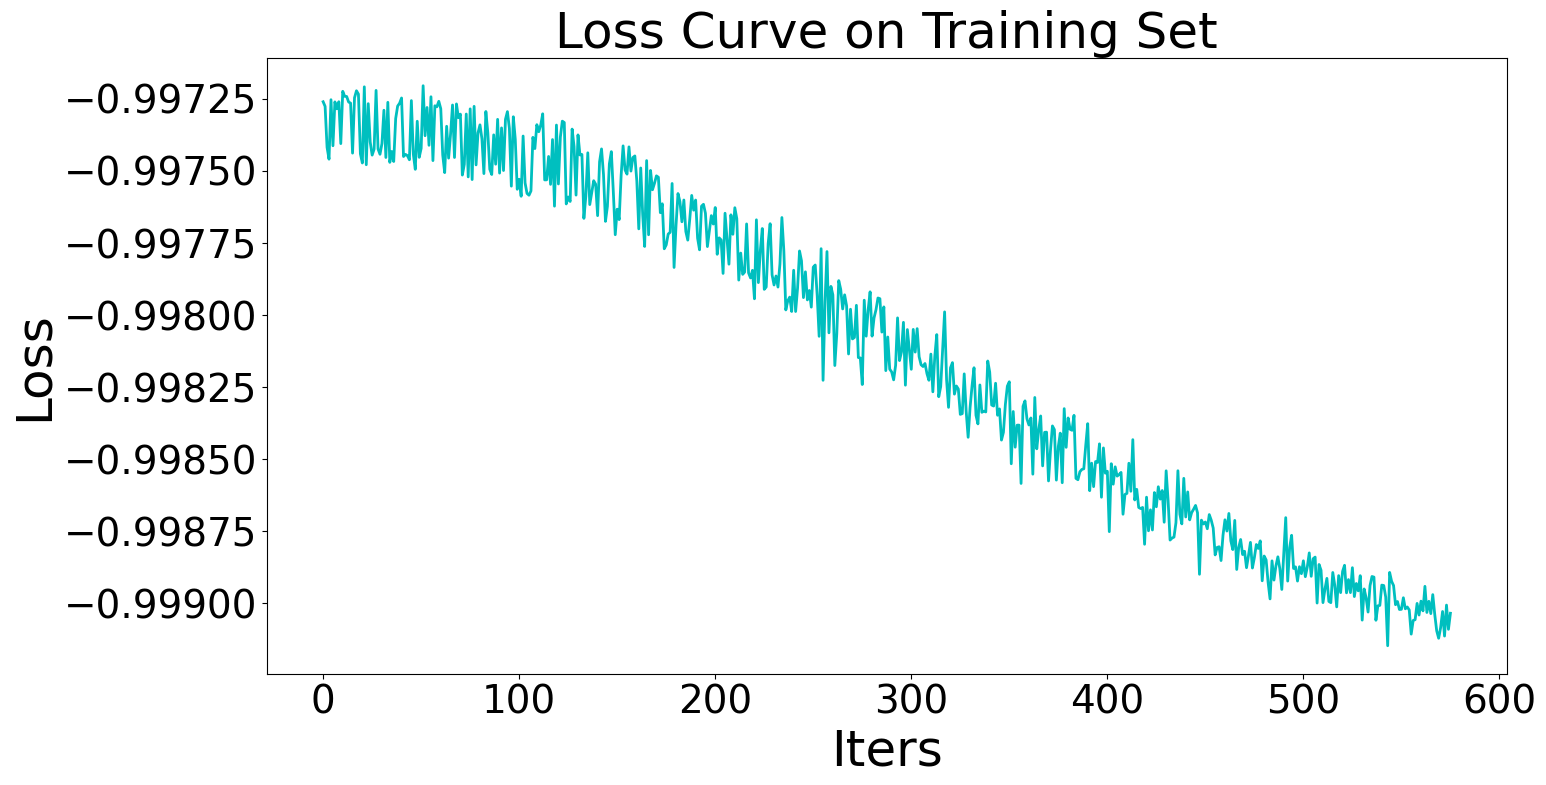

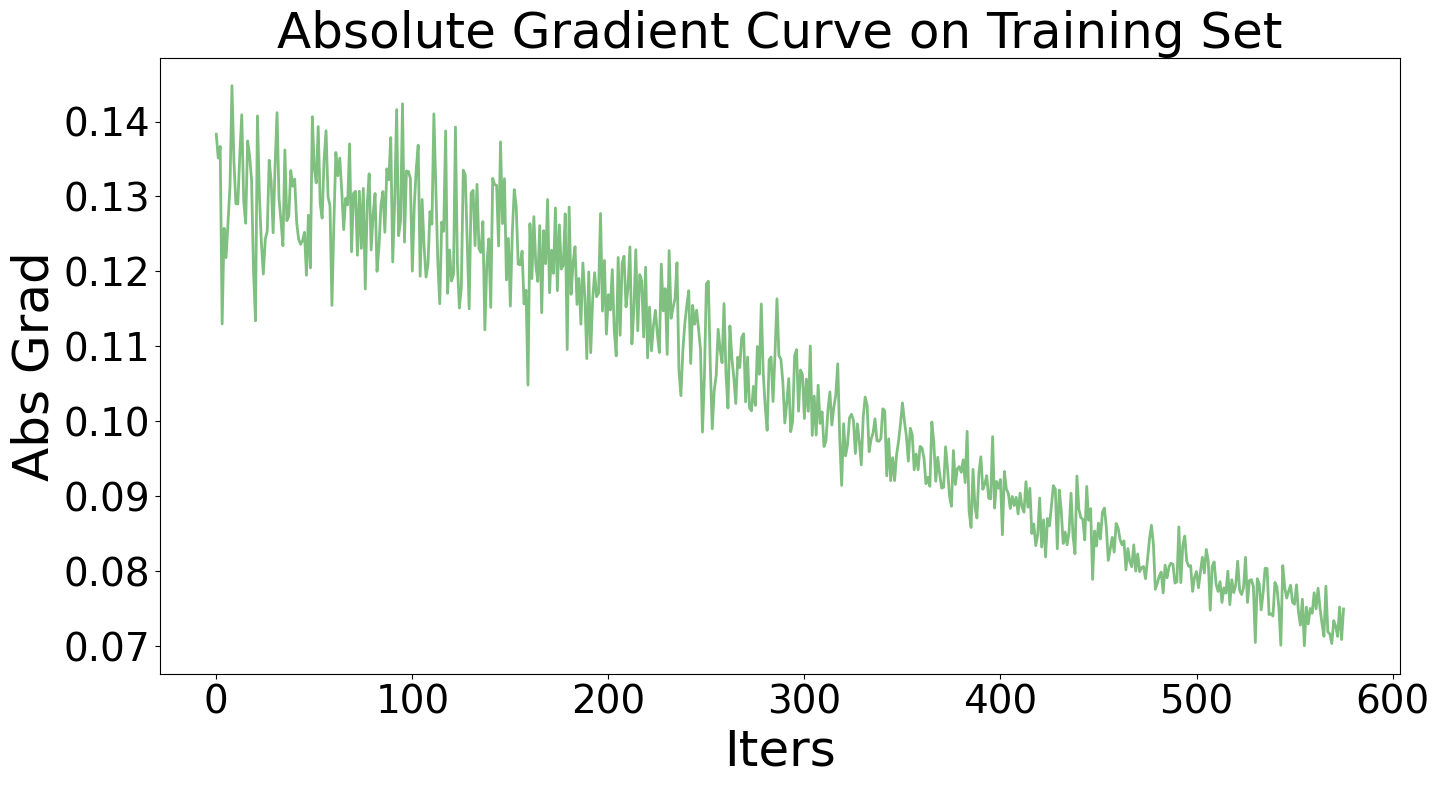

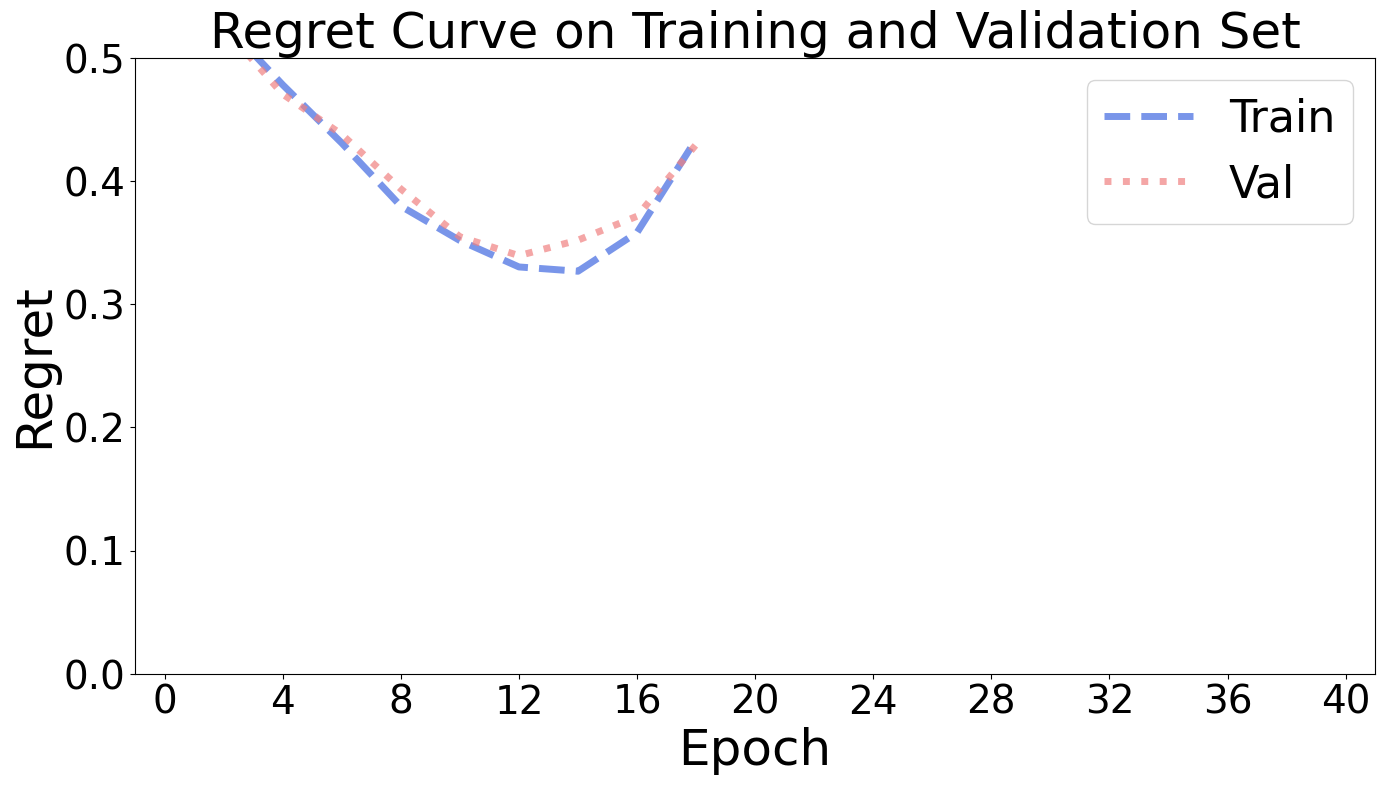

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [48]:
# init model
reg = LinearRegression()

In [49]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [50]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  57.6076%, Val Regret:  58.1007%


Epoch    1, Loss:   5.2500:   5%|██▊                                                    | 2/40 [00:12<02:48,  4.45s/it]

Epoch   2, Train Regret:  14.0680%, Val Regret:  13.7168%


Epoch    3, Loss:   5.1250:  10%|█████▌                                                 | 4/40 [00:21<02:34,  4.30s/it]

Epoch   4, Train Regret:  10.3666%, Val Regret:   8.7815%


Epoch    5, Loss:   4.5000:  15%|████████▎                                              | 6/40 [00:30<02:26,  4.30s/it]

Epoch   6, Train Regret:  10.0741%, Val Regret:   9.0197%


Epoch    7, Loss:   3.8750:  20%|███████████                                            | 8/40 [00:40<02:17,  4.31s/it]

Epoch   8, Train Regret:   9.7036%, Val Regret:   7.5902%


Epoch    9, Loss:   3.8750:  25%|█████████████▌                                        | 10/40 [00:49<02:12,  4.41s/it]

Epoch  10, Train Regret:   9.3039%, Val Regret:   8.1688%


Epoch   11, Loss:   4.5000:  30%|████████████████▏                                     | 12/40 [00:59<02:04,  4.45s/it]

Epoch  12, Train Regret:   9.3072%, Val Regret:   8.7134%


Epoch   13, Loss:   3.8750:  35%|██████████████████▉                                   | 14/40 [01:09<02:08,  4.95s/it]


Epoch  14, Train Regret:   9.3202%, Val Regret:   8.1688%

Early Stop!
Training Elapsed Time: 29.06 Sec

Evaluation:
Test Regret: 9.4379%
Test Elapsed Time: 3.12 Sec


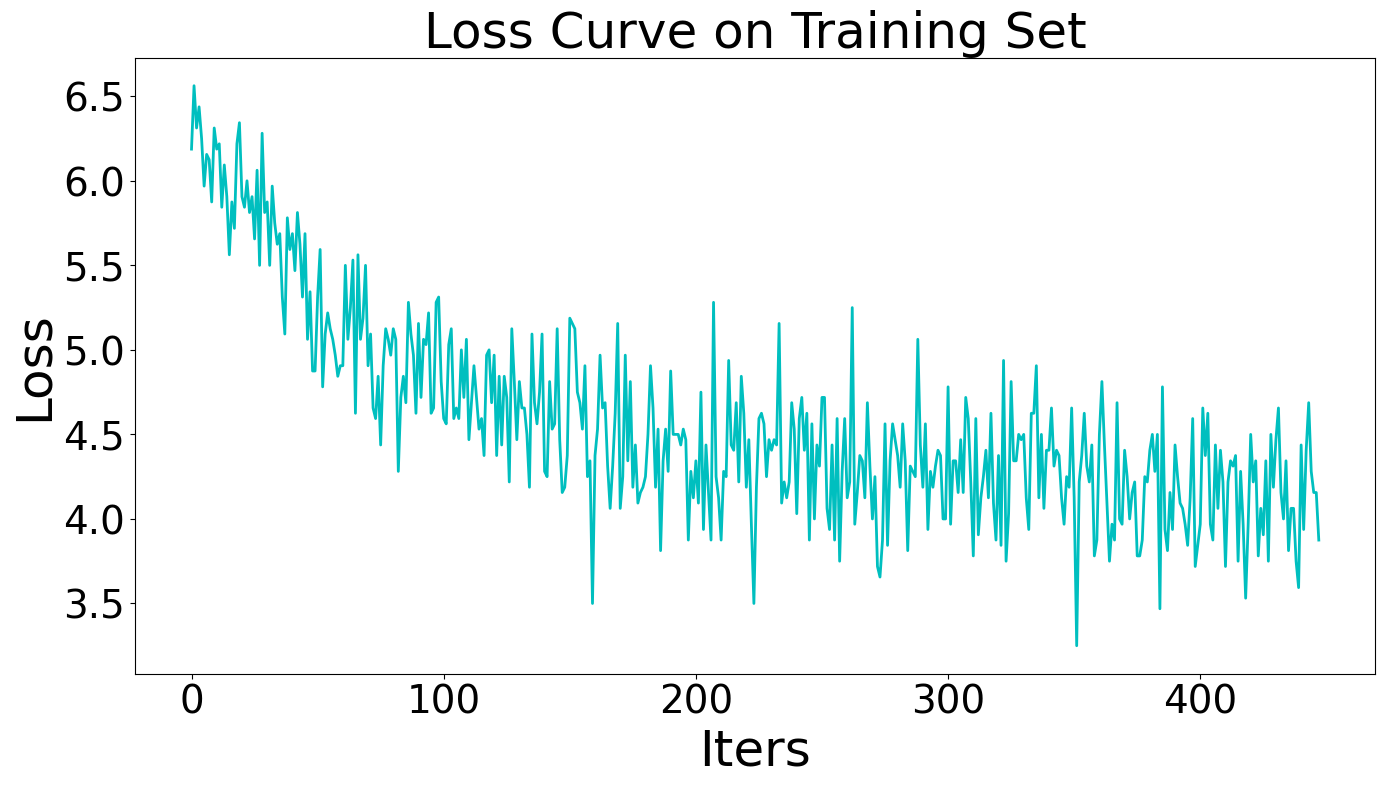

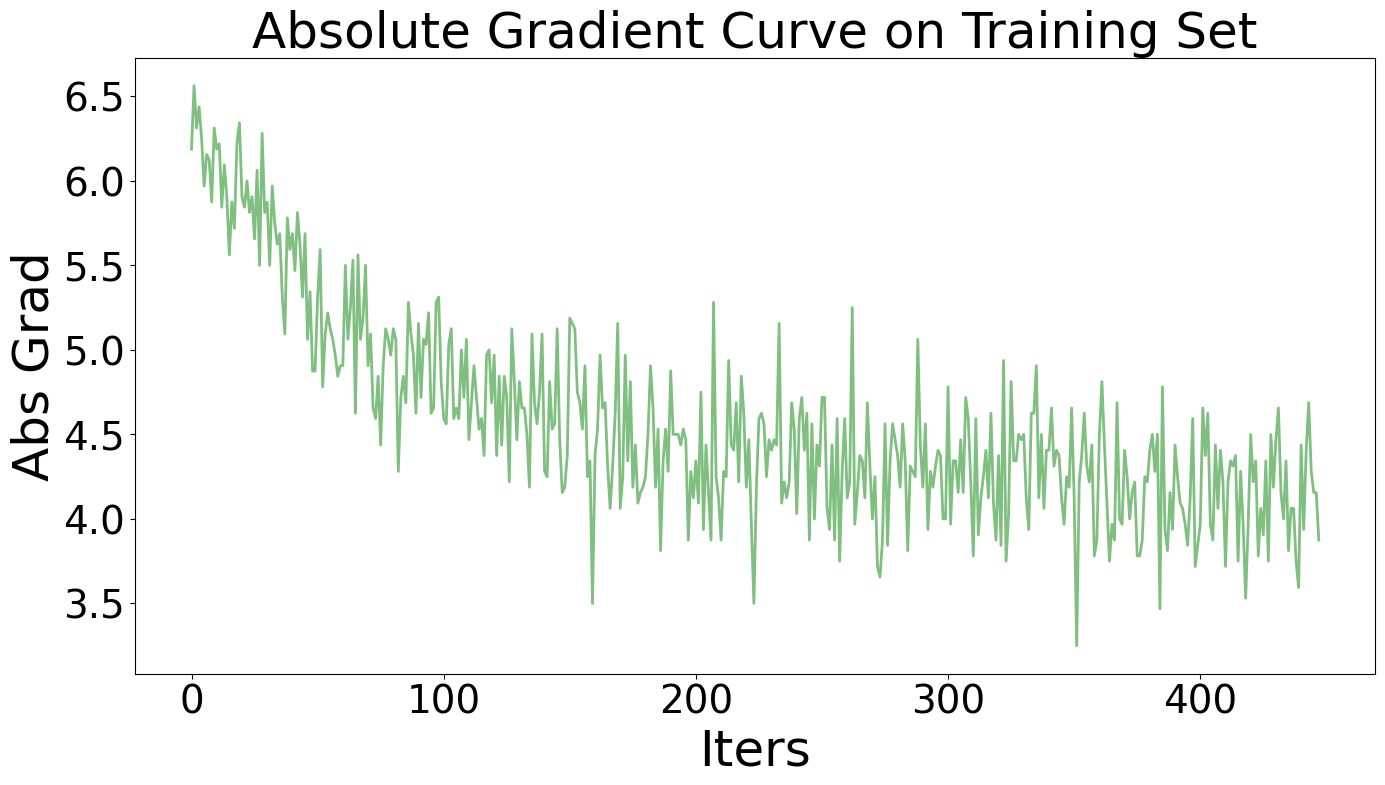

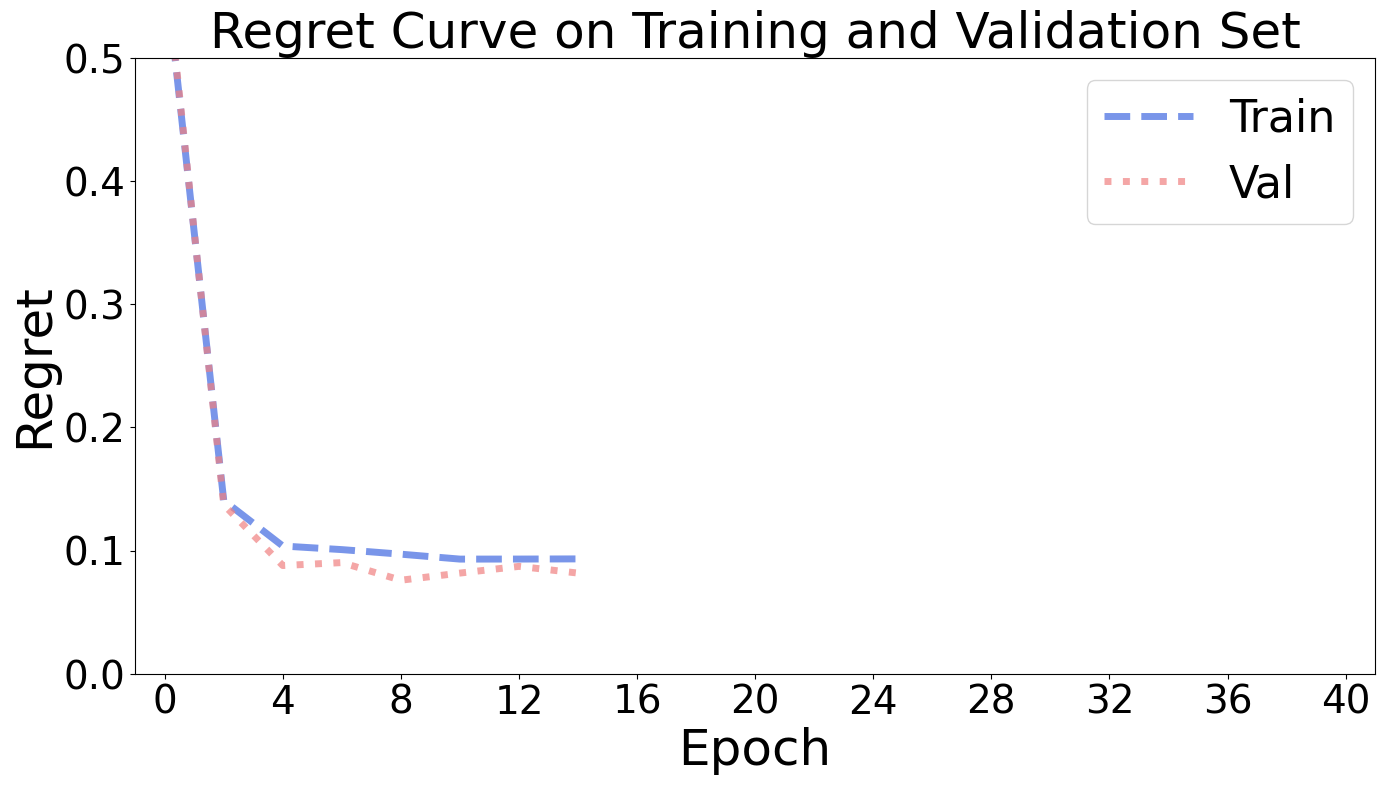

In [51]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [52]:
# init model
reg = LinearRegression()

In [53]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [54]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:03<?, ?it/s]

Epoch   0, Train Regret:  56.1127%, Val Regret:  57.6923%


Epoch    1, Loss:  -3.8441:   5%|██▊                                                    | 2/40 [00:09<01:41,  2.67s/it]

Epoch   2, Train Regret:  20.6324%, Val Regret:  21.9877%


Epoch    3, Loss:  -8.2142:  10%|█████▌                                                 | 4/40 [00:14<01:34,  2.62s/it]

Epoch   4, Train Regret:  12.4106%, Val Regret:  13.3424%


Epoch    5, Loss: -12.1712:  15%|████████▎                                              | 6/40 [00:20<01:28,  2.60s/it]

Epoch   6, Train Regret:  11.1627%, Val Regret:  11.3683%


Epoch    7, Loss: -15.9973:  20%|███████████                                            | 8/40 [00:26<01:22,  2.57s/it]

Epoch   8, Train Regret:  10.8183%, Val Regret:  10.4493%


Epoch    9, Loss: -20.4142:  25%|█████████████▌                                        | 10/40 [00:31<01:17,  2.59s/it]

Epoch  10, Train Regret:  10.5421%, Val Regret:   9.8366%


Epoch   11, Loss: -24.2557:  30%|████████████████▏                                     | 12/40 [00:37<01:12,  2.58s/it]

Epoch  12, Train Regret:  10.4023%, Val Regret:   9.6664%


Epoch   13, Loss: -27.5479:  35%|██████████████████▉                                   | 14/40 [00:42<01:04,  2.47s/it]

Epoch  14, Train Regret:  10.2658%, Val Regret:   9.6324%


Epoch   15, Loss: -34.2040:  40%|█████████████████████▌                                | 16/40 [00:48<00:59,  2.47s/it]

Epoch  16, Train Regret:  10.1651%, Val Regret:   9.2580%


Epoch   17, Loss: -36.7002:  45%|████████████████████████▎                             | 18/40 [00:54<00:56,  2.55s/it]

Epoch  18, Train Regret:  10.1813%, Val Regret:   9.1899%


Epoch   19, Loss: -48.0914:  50%|███████████████████████████                           | 20/40 [00:59<00:50,  2.53s/it]

Epoch  20, Train Regret:  10.1813%, Val Regret:   9.2580%


Epoch   21, Loss: -55.4549:  55%|█████████████████████████████▋                        | 22/40 [01:04<00:43,  2.44s/it]

Epoch  22, Train Regret:  10.2008%, Val Regret:   9.2240%


Epoch   23, Loss: -44.7370:  60%|████████████████████████████████▍                     | 24/40 [01:10<00:38,  2.41s/it]

Epoch  24, Train Regret:  10.1878%, Val Regret:   9.1559%


Epoch   25, Loss: -54.0658:  65%|███████████████████████████████████                   | 26/40 [01:15<00:34,  2.43s/it]

Epoch  26, Train Regret:  10.2463%, Val Regret:   9.1559%


Epoch   27, Loss: -45.8557:  70%|█████████████████████████████████████▊                | 28/40 [01:21<00:29,  2.49s/it]

Epoch  28, Train Regret:  10.2593%, Val Regret:   9.0538%


Epoch   29, Loss: -81.0722:  75%|████████████████████████████████████████▌             | 30/40 [01:27<00:25,  2.53s/it]

Epoch  30, Train Regret:  10.2756%, Val Regret:   9.1899%


Epoch   31, Loss: -89.2186:  80%|███████████████████████████████████████████▏          | 32/40 [01:32<00:20,  2.51s/it]

Epoch  32, Train Regret:  10.3178%, Val Regret:   9.2580%


Epoch   33, Loss: -64.3865:  85%|█████████████████████████████████████████████▉        | 34/40 [01:38<00:17,  2.89s/it]


Epoch  34, Train Regret:  10.2886%, Val Regret:   9.2580%

Early Stop!
Training Elapsed Time: 7.37 Sec

Evaluation:
Test Regret: 9.8570%
Test Elapsed Time: 2.74 Sec


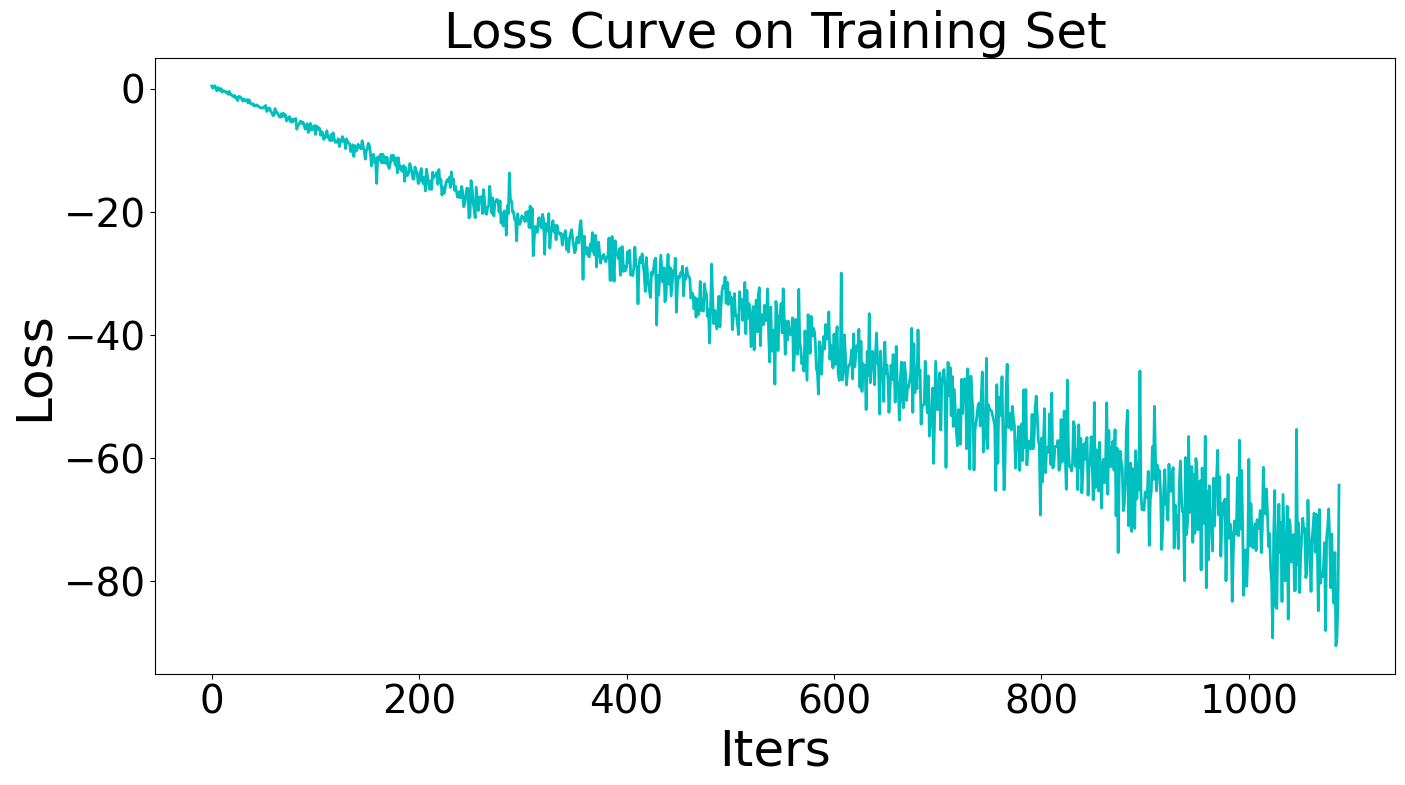

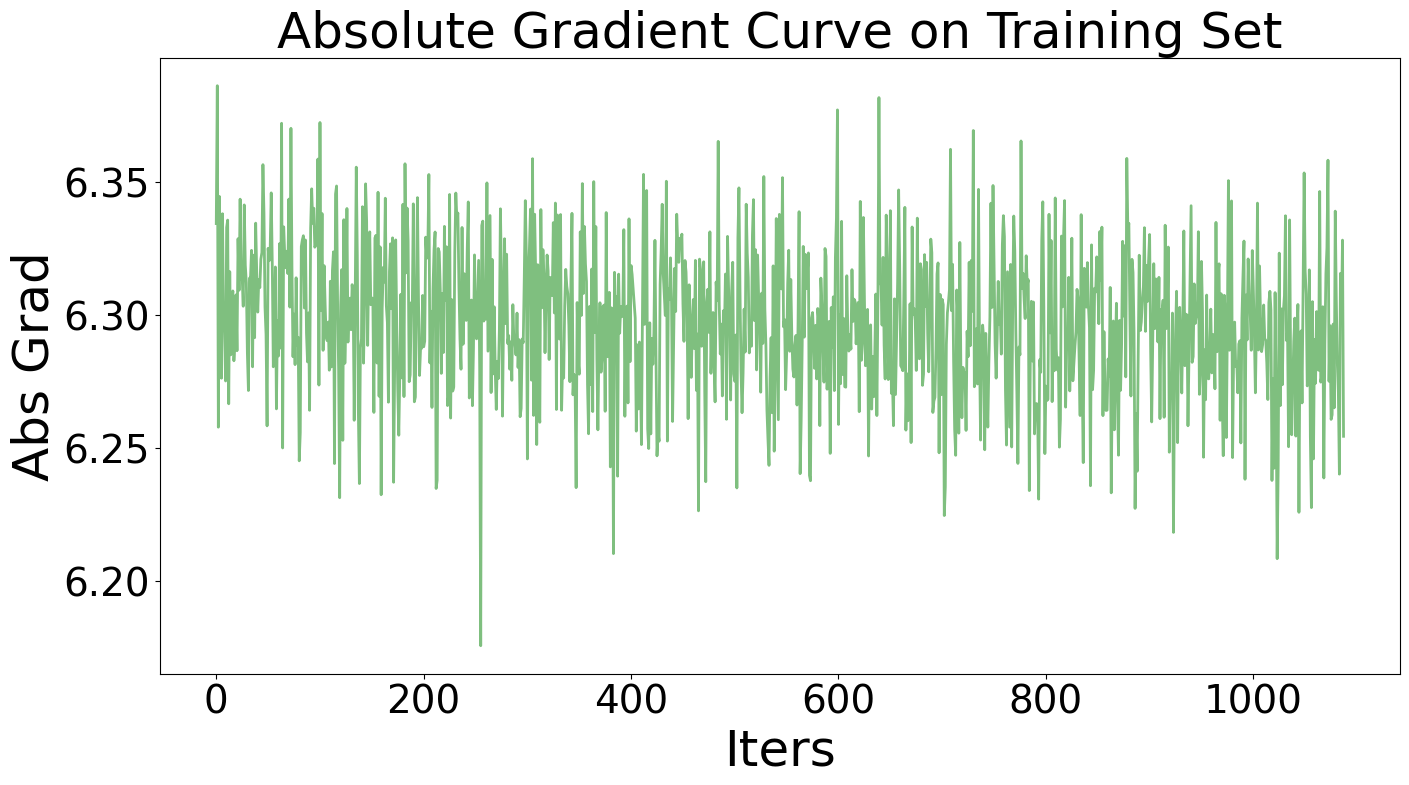

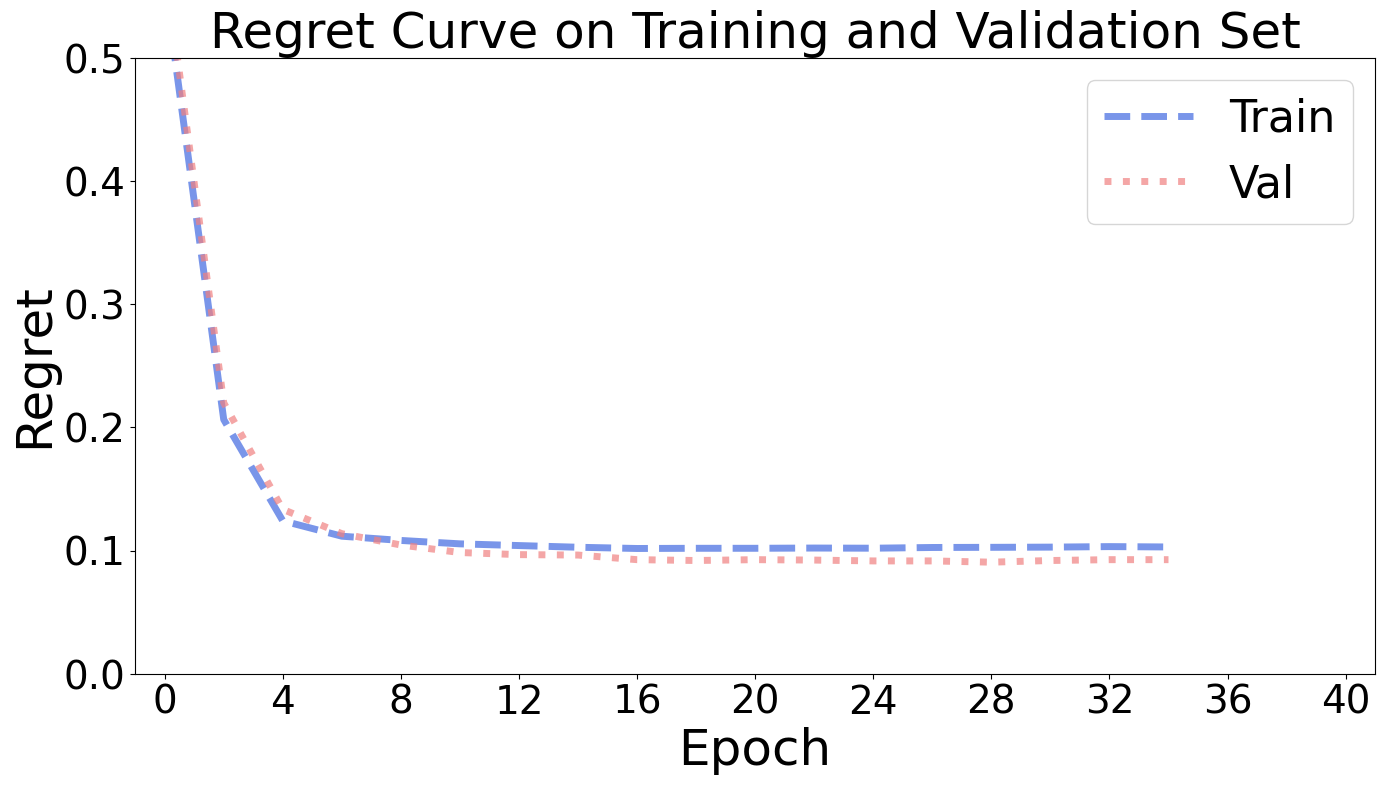

In [55]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)